# VideoMAE - Classification

Note that the feature extraction pipeline is given in the VideoMAE Regression file. 

## Imports and config

In [21]:
import os
from pathlib import Path
import copy
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import optuna
from optuna.samplers import TPESampler

from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import label_binarize

# ----------------------------- global knobs (match regression) -----------------------------
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 5
N_EPOCHS = 40
PATIENCE = 10
N_TRIALS = 30
FEATURE_DIR = "videomae_features_new"
MODEL_DIR = Path("models_final")
MODEL_DIR.mkdir(exist_ok=True)
RESULTS_DIR = Path("results_final")
RESULTS_DIR.mkdir(exist_ok=True)
PIN = torch.cuda.is_available()
NUM_WORKERS = 0

CSV_PATH = "FinalDataset.csv"
NUM_CLASSES = 5  # adjust if your encoding uses a different count

# Two label columns → choose by split name
LABEL_COL_MAP = {
    "ind": "view_range_enc_ind",
    "dep": "view_range_enc_dep",
}

def set_seed(seed: int = SEED):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# Dataset Class

In [22]:
class TemporalFeatureDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, feature_dir: str, target_column: str):
        self.df = dataframe.reset_index(drop=True)
        self.feature_dir = feature_dir     # Base directory containing .npy feature files
        self.target_column = target_column

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]   # select the idx-th row
        video_id = row["video_id"]
        feature_path = os.path.join(self.feature_dir, f"{video_id}_temporal.npy") 
        features = np.load(feature_path)  # load features: expected shape [T, D]
        label = int(row[self.target_column])  # fetch the target for this sample
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)  # Convert to Pytorch tensors

# Model - Transformer

In [23]:
class TransformerClassifier(nn.Module):
    def __init__(self, d_model=768, nhead=8, num_layers=2, num_classes=5):
        super().__init__()
        # One encoder block (self-attention + FFN + residual + norm)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers) # Stack 'num_layers' encoder blocks
        self.classifier = nn.Linear(d_model, num_classes) # Linear classifier head mapping pooled [B, D] -> [B, num_classes].

    def forward(self, x):  # x: (B, T, D)
        x = x.permute(1, 0, 2)         # Permute as by default the transformer expects [T, B, D]
        x = self.transformer(x)        # (T, B, D)
        x = x.mean(dim=0)              # global average pooling over time
        return self.classifier(x)      # Project to class logits - (B, num_classes)

# Training Loop

In [24]:
def acc_f1_from_logits(logits: np.ndarray, targets: np.ndarray):
    preds = logits.argmax(axis=1)   # predicted class = argmax over classes
    acc = accuracy_score(targets, preds)  # overall accuracy
    f1  = f1_score(targets, preds, average="macro")  # macro-F1 (treats classes equally)
    return float(acc), float(f1)

def train_one_epoch(model, loader, criterion, optimizer, clip_norm: float = 1.0):
    model.train()     # Set the model in train mode
    total_loss, n = 0.0, 0
    logits_all, tgts_all = [], []

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)   # Move to device
        y = y.to(DEVICE, non_blocking=True)   # Move to device

        optimizer.zero_grad(set_to_none=True)   # Instead of setting to 0, set the grads to None - slightly faster
        logits = model(x)                 # forward pass -> logits (B, C)
        loss = criterion(logits, y)       # Cross Entropy loss (expects long targets)
        loss.backward()                # Backpropagation
        
        if clip_norm is not None:        # optional grad-norm clipping for stability
            nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            
        optimizer.step()                    # apply updates

        bs = x.size(0)               # batch size
        total_loss += loss.item() * bs    # accumulate sum of loss over samples
        n += bs       # accumulate sample count

        logits_all.append(logits.detach().cpu())   # Stash logits on CPU
        tgts_all.append(y.detach().cpu())         # Stash targets on CPU

    if n == 0:
        return float("nan"), float("nan"), float("nan")

    # Concatenate all batches
    logits_all = torch.cat(logits_all, dim=0).numpy()
    tgts_all   = torch.cat(tgts_all,   dim=0).numpy()
    
    acc, f1 = acc_f1_from_logits(logits_all, tgts_all)   # Compute accuracy and macro-F1
    avg_ce = total_loss / n             # convert summed loss to mean over samples
    return avg_ce, acc, f1


@torch.no_grad()                 # disable autograd for evaluation
def evaluate(model, loader, criterion=None):
    model.eval()         # Set eval mode
    total_loss, n = 0.0, 0
    logits_all, tgts_all = [], []

    # Build/default CE once, move to DEVICE
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(DEVICE)

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)   # Move inputs to device
        y = y.to(DEVICE, non_blocking=True)   # Move targets to device

        logits = model(x)       # (B, C)
        loss = criterion(logits, y)   # CE on this batch

        batch_size = x.size(0)
        total_loss += loss.item() * batch_size     # accumulate sum of losses
        n += batch_size

        logits_all.append(logits.detach().cpu())
        tgts_all.append(y.detach().cpu())

    if n == 0:
        # empty split safety
        return float("nan"), float("nan"), float("nan"), np.empty((0,)), np.empty((0,)), np.empty((0,))

    logits_all = torch.cat(logits_all, dim=0).numpy()     # (N, C)
    tgts_all   = torch.cat(tgts_all,   dim=0).numpy()     # (N,)
    probs = torch.softmax(torch.from_numpy(logits_all), dim=1).numpy()   # convert logits -> probs

    acc, f1 = acc_f1_from_logits(logits_all, tgts_all)
    avg_ce = total_loss / n         # mean cross entropy over samples
    return avg_ce, acc, f1, probs, logits_all, tgts_all


def class_weights_from_df(train_df, target_col, num_classes):
    # Count per class using integer labels {0..num_classes-1}; fill missing with 0
    counts = train_df[target_col].value_counts().reindex(range(num_classes), fill_value=0).astype(float).values
    total = counts.sum()
    if total <= 0:
        # no training data- fall back to uniform
        return torch.ones(num_classes, dtype=torch.float32, device=DEVICE)
    
    weights = total / (num_classes * np.maximum(counts, 1.0)) # Inverse-frequency scaling: total/(num_classes * count_c)
    weights = np.maximum(weights, 1e-6)  # avoid zeros
    return torch.tensor(weights, dtype=torch.float32, device=DEVICE)    # Return a tensor of weights

def train_and_evaluate(model, train_loader, val_loader, lr, weight_decay,
                       n_epochs=N_EPOCHS, patience=PATIENCE, class_weights=None):
    crit = nn.CrossEntropyLoss(weight=class_weights).to(DEVICE)   # Build CE with weights 
    opt  = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Adam optimizer with weight decay

    best_val_acc = -1.0
    best_state = None; bad = 0; best_f1 = 0.0
    
    for ep in range(1, n_epochs + 1):
        tr_ce, tr_acc, tr_f1 = train_one_epoch(model, train_loader, crit, opt) # One epoch of training (returns mean CE/Acc/F1 over the epoch)
        va_ce, va_acc, va_f1, _, _, _ = evaluate(model, val_loader, crit)  # Validation (no grad)
        print(f"Epoch {ep:02d}: Train Loss={tr_ce:.4f}, Acc={tr_acc:.4f}, F1={tr_f1:.4f} | "
              f"Val Loss={va_ce:.4f}, Acc={va_acc:.4f}, F1={va_f1:.4f}")
        if va_acc > best_val_acc:
            best_val_acc, best_f1 = float(va_acc), float(va_f1)    # save metrics
            best_state = copy.deepcopy(model.state_dict())         # save weights
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping"); break

    # Restore best checkpoint before returning
    model.load_state_dict(best_state)
    return model, best_val_acc, best_f1

# Optuna - Hyperparameter Tuning

In [25]:
# ------------------------------ optuna objective (mirrors reg) ------------------------------
def objective_builder(train_df, val_df, input_dim=768, target_col="view_range_enc_ind"):
    def objective(trial):
        print(f"\n[trial {trial.number}] build loaders...", flush=True)
        g = torch.Generator().manual_seed(SEED + trial.number)  # trial-specific RNG for shuffle order
        train_loader = DataLoader(
            TemporalFeatureDataset(train_df, FEATURE_DIR, target_col),
            batch_size=BATCH_SIZE, shuffle=True, generator=g,
            num_workers=NUM_WORKERS, pin_memory=PIN
        )
        val_loader = DataLoader(
            TemporalFeatureDataset(val_df, FEATURE_DIR, target_col),
            batch_size=BATCH_SIZE, shuffle=False,   # same dataset, no shuffle for val
            num_workers=NUM_WORKERS, pin_memory=PIN
        )

        # hyperparams (kept parallel to regression)
        nhead       = trial.suggest_categorical("nhead", [4, 8])   # Suggests either 4 or 8
        num_layers  = trial.suggest_int("num_layers", 1, 4)        # Suggests any integer between 1 to 4
        lr          = trial.suggest_float("lr", 1e-4, 1e-2, log=True)   # Suggests any positive float between the range sampled log uniformly
        weight_decay= trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True) # Any positive float - also log uniform

        model = TransformerClassifier(d_model=input_dim, nhead=nhead, num_layers=num_layers,
                                      num_classes=NUM_CLASSES).to(DEVICE)  # Model instance

        # class weights per split/target
        cw = class_weights_from_df(train_df, target_col, NUM_CLASSES)

        # Train and validate
        model, val_acc, val_f1 = train_and_evaluate(
            model, train_loader, val_loader, lr, weight_decay,
            n_epochs=N_EPOCHS, patience=PATIENCE, class_weights=cw
        )
        
        # Attach useful artifacts to the trial for later inspection
        trial.set_user_attr("val_acc", float(val_acc))
        trial.set_user_attr("val_f1", float(val_f1))
        trial.set_user_attr("state_dict", copy.deepcopy(model.state_dict()))
        
        return float(val_acc) # maximize accuracy
    return objective

# Run Experiment

In [26]:
# ------------------------ plotting helpers (heatmap + ROC) ------------------------
def plot_confusion_heatmap(y_true, y_pred, num_classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))   # Get the confusion matrix
    plt.figure(figsize=(6.5, 5.5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",     # Plot the heatmap of the confusion matrix for better visualisation
                xticklabels=[f"{i}" for i in range(num_classes)],   # Predicted class labels
                yticklabels=[f"{i}" for i in range(num_classes)])   # True class labels
    plt.xlabel("Predicted")
    plt.ylabel("True") 
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return cm         # Return counts for further analysis

def plot_multiclass_roc(y_true, probs, num_classes, title):
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes))) # Binarize in one vs all fashion
    plt.figure(figsize=(7.5, 6))
    any_class = False    # Track if at least one class is plottable
    for c in range(num_classes):          # Plot per class ROC
        if y_true_bin[:, c].sum() == 0:         # Skip if no positive samples for the true values
            continue
        fpr, tpr, _ = roc_curve(y_true_bin[:, c], probs[:, c])  # ROC for class c vs rest
        auc_c = auc(fpr, tpr)         # AUC for class c
        plt.plot(fpr, tpr, lw=1.8, label=f"Class {c} (AUC={auc_c:.3f})")   # Add curve to the plot
        any_class = True
    # micro-average
    try:
        auc_micro = roc_auc_score(y_true_bin, probs, average="micro", multi_class="ovr")
        fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), probs.ravel()) # Compute micro-average ROC curve by flattening all decisions
        plt.plot(fpr_micro, tpr_micro, lw=2.2, linestyle="--", label=f"Micro (AUC={auc_micro:.3f})")
    except Exception:
        auc_micro = np.nan
    plt.plot([0,1],[0,1],"k--", lw=1)    # diagonal reference
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title + ("" if any_class else " (no per-class ROC: missing labels)"))
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()
    return auc_micro

In [27]:
def run_split(name: str, train_ids: list, val_ids: list, input_dim: int = 768):
    assert name in LABEL_COL_MAP, f"name must be one of {list(LABEL_COL_MAP.keys())}"
    target_col = LABEL_COL_MAP[name]

    print(f"\n=== Running CLASSIFICATION split: {name} (target: {target_col}) ===")

    df = pd.read_csv(CSV_PATH)
    train_df = df[df.video_id.isin(train_ids)].reset_index(drop=True)
    val_df   = df[df.video_id.isin(val_ids)].reset_index(drop=True)

    # Optuna (maximize accuracy)
    study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=SEED))
    study.optimize(objective_builder(train_df, val_df, input_dim, target_col), n_trials=N_TRIALS)
    best = study.best_params   # Get the best trial
    print("Best hyper-parameters:", best)
    print("Best Val ACC (Optuna):", study.best_trial.value, "| Val F1:", study.best_trial.user_attrs["val_f1"])

    # Rebuild best model and load exact best-epoch weights
    model = TransformerClassifier(
        d_model=input_dim, nhead=best["nhead"], num_layers=best["num_layers"], num_classes=NUM_CLASSES
    ).to(DEVICE)
    model.load_state_dict(study.best_trial.user_attrs["state_dict"])

    # Eval loaders (no shuffle)
    train_loader = DataLoader(TemporalFeatureDataset(train_df, FEATURE_DIR, target_col),
                              batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN)
    val_loader   = DataLoader(TemporalFeatureDataset(val_df, FEATURE_DIR, target_col),
                              batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN)

    # Re-evaluate the reloaded model to verify results with Optuna’s numbers
    tr_ce, tr_acc, tr_f1, tr_probs, tr_logits, tr_tgts = evaluate(model, train_loader)
    va_ce, va_acc, va_f1, va_probs, va_logits, va_tgts = evaluate(model, val_loader)
    print(f"Reloaded eval — Train Acc={tr_acc:.4f}, F1={tr_f1:.4f} | "
          f"Val Acc={va_acc:.4f}, F1={va_f1:.4f} | ΔACC={abs(va_acc - study.best_trial.value):.6f}")

    # Save bundle + study 
    bundle_path = MODEL_DIR / f"video_cls_{name}.pt"
    torch.save({
        "state_dict": study.best_trial.user_attrs["state_dict"],
        "best_params": best,
        "val_acc": study.best_trial.value,
        "val_f1": study.best_trial.user_attrs["val_f1"],
        "num_classes": NUM_CLASSES,
        "target_col": target_col,
    }, bundle_path)

    with open(MODEL_DIR / f"video_cls_{name}.pkl", "wb") as f:
        pickle.dump(study, f)  # Save the full Optuna study

    # Save VAL predictions (for fusion)
    va_pred = va_probs.argmax(axis=1)   # predicted class per sample (N,)
    out = pd.DataFrame({
        "video_id": val_df["video_id"].values,  # aligns with val_loader order since shuffle=False
        "y_true":   va_tgts.astype(int),
        "y_pred":   va_pred.astype(int),
    })
    for c in range(NUM_CLASSES):
        out[f"prob_class_{c}"] = va_probs[:, c]  # Append per-class probabilities as columns: prob_class_0 .. prob_class_{C-1}
    fname = RESULTS_DIR / f"video_cls_val_{name}.csv"
    out.to_csv(fname, index=False)
    print(f"Saved VAL preds → {fname}")

    # Confusion matrix (HEATMAP)
    cm = plot_confusion_heatmap(va_tgts, va_pred, NUM_CLASSES, f"Confusion Matrix (VAL) — {name}")
    print("\nClassification Report (VAL):\n",
          classification_report(va_tgts, va_pred, labels=list(range(NUM_CLASSES)), digits=4, zero_division=0)) # Detailed per-class precision/recall/F1 report

    # ROC curves (multi-class)
    auc_micro = plot_multiclass_roc(va_tgts, va_probs, NUM_CLASSES, f"ROC Curves (VAL) — {name}")
    try:      # Macro-average AUC (may fail if some classes are entirely missing)
        y_true_bin = label_binarize(va_tgts, classes=list(range(NUM_CLASSES)))
        auc_macro = roc_auc_score(y_true_bin, va_probs, average="macro", multi_class="ovr")
    except Exception:
        auc_macro = np.nan
    print(f"\nAUC-ROC (VAL): micro {auc_micro:.4f} | macro {auc_macro:.4f}")

    return {
        "model": model,
        "train_df": train_df, "val_df": val_df,
        "vl_probs": va_probs, "vl_logits": va_logits, "vl_tgts": va_tgts,
        "vl_acc": va_acc, "vl_f1": va_f1,
        "bundle_path": bundle_path,
        "val_csv": fname
    }

# Person - Independent Split

[I 2025-08-16 18:39:11,329] A new study created in memory with name: no-name-6490882c-b6a2-42fe-b54a-ace4648a194e



=== Running CLASSIFICATION split: ind (target: view_range_enc_ind) ===

[trial 0] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.6233, Acc=0.1933, F1=0.1858 | Val Loss=2.1618, Acc=0.2200, F1=0.0721
Epoch 02: Train Loss=1.8027, Acc=0.2167, F1=0.2181 | Val Loss=1.6407, Acc=0.2600, F1=0.0825
Epoch 03: Train Loss=1.7734, Acc=0.1833, F1=0.1742 | Val Loss=1.7055, Acc=0.2600, F1=0.0825
Epoch 04: Train Loss=1.7488, Acc=0.1767, F1=0.1732 | Val Loss=1.7002, Acc=0.1000, F1=0.0364
Epoch 05: Train Loss=1.6886, Acc=0.1800, F1=0.1709 | Val Loss=1.6694, Acc=0.2600, F1=0.0825
Epoch 06: Train Loss=1.6893, Acc=0.1867, F1=0.1820 | Val Loss=1.7222, Acc=0.1000, F1=0.0364
Epoch 07: Train Loss=1.6721, Acc=0.2100, F1=0.2038 | Val Loss=1.5760, Acc=0.2600, F1=0.0825
Epoch 08: Train Loss=1.6692, Acc=0.1767, F1=0.1683 | Val Loss=1.7620, Acc=0.1000, F1=0.0364
Epoch 09: Train Loss=1.6624, Acc=0.1833, F1=0.1689 | Val Loss=1.7568, Acc=0.1000, F1=0.0364
Epoch 10: Train Loss=1.6478, Acc=0.1800, F1=0.1699 | Val Loss=1.6421, Acc=0.2600, F1=0.0825
Epoch 11: Train Loss=1.6494, Acc=0.2067, F1=0.1936 | Val Loss=1.5809, Acc=0.2600

[I 2025-08-16 18:40:26,126] Trial 0 finished with value: 0.26 and parameters: {'nhead': 8, 'num_layers': 3, 'lr': 0.0015751320499779737, 'weight_decay': 2.9380279387035354e-06}. Best is trial 0 with value: 0.26.


Epoch 12: Train Loss=1.6466, Acc=0.1867, F1=0.1618 | Val Loss=1.6074, Acc=0.2600, F1=0.0825
Early stopping

[trial 1] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.4603, Acc=0.2333, F1=0.2196 | Val Loss=1.7023, Acc=0.1600, F1=0.0552
Epoch 02: Train Loss=1.8486, Acc=0.2367, F1=0.2252 | Val Loss=1.8765, Acc=0.2600, F1=0.0825
Epoch 03: Train Loss=1.7740, Acc=0.1800, F1=0.1631 | Val Loss=1.8801, Acc=0.2600, F1=0.0825
Epoch 04: Train Loss=1.7789, Acc=0.1367, F1=0.1306 | Val Loss=1.5892, Acc=0.2600, F1=0.0825
Epoch 05: Train Loss=1.6682, Acc=0.2167, F1=0.1945 | Val Loss=1.5895, Acc=0.2200, F1=0.0721
Epoch 06: Train Loss=1.6883, Acc=0.1633, F1=0.1450 | Val Loss=1.7097, Acc=0.2600, F1=0.0825
Epoch 07: Train Loss=1.6833, Acc=0.1733, F1=0.1513 | Val Loss=1.7061, Acc=0.1600, F1=0.0552
Epoch 08: Train Loss=1.6701, Acc=0.2167, F1=0.1822 | Val Loss=1.6712, Acc=0.1000, F1=0.0364
Epoch 09: Train Loss=1.6434, Acc=0.1933, F1=0.1594 | Val Loss=1.8349, Acc=0.1200, F1=0.0732
Epoch 10: Train Loss=1.6352, Acc=0.2200, F1=0.1892 | Val Loss=1.6985, Acc=0.2600, F1=0.0825
Epoch 11: Train Loss=1.6613, Acc=0.2067, F1=0.1946 | Val Loss=1.7169, Acc=0.1000

[I 2025-08-16 18:41:58,152] Trial 1 finished with value: 0.26 and parameters: {'nhead': 4, 'num_layers': 4, 'lr': 0.0015930522616241021, 'weight_decay': 0.000133112160807369}. Best is trial 0 with value: 0.26.


Epoch 12: Train Loss=1.6481, Acc=0.1900, F1=0.1527 | Val Loss=1.5873, Acc=0.2600, F1=0.0825
Early stopping

[trial 2] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.1024, Acc=0.1333, F1=0.1287 | Val Loss=1.6039, Acc=0.2600, F1=0.0825
Epoch 02: Train Loss=1.6772, Acc=0.2267, F1=0.2187 | Val Loss=1.8610, Acc=0.1600, F1=0.0932
Epoch 03: Train Loss=1.6477, Acc=0.3233, F1=0.2968 | Val Loss=1.5401, Acc=0.3200, F1=0.1741
Epoch 04: Train Loss=1.6660, Acc=0.2467, F1=0.2364 | Val Loss=1.7568, Acc=0.1200, F1=0.0867
Epoch 05: Train Loss=1.5795, Acc=0.2967, F1=0.2753 | Val Loss=1.7506, Acc=0.3000, F1=0.1623
Epoch 06: Train Loss=1.5205, Acc=0.3200, F1=0.3097 | Val Loss=1.5473, Acc=0.3200, F1=0.1971
Epoch 07: Train Loss=1.5581, Acc=0.3000, F1=0.2873 | Val Loss=1.6896, Acc=0.3600, F1=0.2556
Epoch 08: Train Loss=1.5020, Acc=0.3600, F1=0.3281 | Val Loss=1.6376, Acc=0.1600, F1=0.0552
Epoch 09: Train Loss=1.5510, Acc=0.3133, F1=0.3129 | Val Loss=1.5713, Acc=0.3200, F1=0.2193
Epoch 10: Train Loss=1.4818, Acc=0.3100, F1=0.2631 | Val Loss=1.5696, Acc=0.2200, F1=0.1414
Epoch 11: Train Loss=1.5337, Acc=0.3133, F1=0.2907 | Val Loss=1.6420, Acc=0.2800

[I 2025-08-16 18:44:16,070] Trial 2 finished with value: 0.36 and parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.00026587543983272726, 'weight_decay': 3.5113563139704077e-06}. Best is trial 2 with value: 0.36.


Epoch 17: Train Loss=1.4647, Acc=0.3167, F1=0.2924 | Val Loss=1.5540, Acc=0.3000, F1=0.1514
Early stopping

[trial 3] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.3817, Acc=0.1700, F1=0.1672 | Val Loss=1.7530, Acc=0.2200, F1=0.0721
Epoch 02: Train Loss=1.7510, Acc=0.1633, F1=0.1618 | Val Loss=1.9110, Acc=0.1000, F1=0.0364
Epoch 03: Train Loss=1.7876, Acc=0.1967, F1=0.1949 | Val Loss=1.5832, Acc=0.2600, F1=0.0825
Epoch 04: Train Loss=1.7304, Acc=0.2300, F1=0.2246 | Val Loss=1.7744, Acc=0.1600, F1=0.0552
Epoch 05: Train Loss=1.6849, Acc=0.2033, F1=0.1797 | Val Loss=1.6336, Acc=0.2600, F1=0.0825
Epoch 06: Train Loss=1.6966, Acc=0.1767, F1=0.1674 | Val Loss=1.6874, Acc=0.1000, F1=0.0364
Epoch 07: Train Loss=1.6801, Acc=0.1733, F1=0.1461 | Val Loss=1.8985, Acc=0.1000, F1=0.0364
Epoch 08: Train Loss=1.6795, Acc=0.1800, F1=0.1471 | Val Loss=1.6928, Acc=0.1000, F1=0.0364
Epoch 09: Train Loss=1.6993, Acc=0.1667, F1=0.1438 | Val Loss=1.6659, Acc=0.1600, F1=0.0552
Epoch 10: Train Loss=1.6727, Acc=0.1767, F1=0.1603 | Val Loss=1.7040, Acc=0.1600, F1=0.0552
Epoch 11: Train Loss=1.6434, Acc=0.2367, F1=0.1993 | Val Loss=1.5881, Acc=0.2200

[I 2025-08-16 18:45:36,707] Trial 3 finished with value: 0.26 and parameters: {'nhead': 8, 'num_layers': 3, 'lr': 0.0007309539835912913, 'weight_decay': 7.4763120622522945e-06}. Best is trial 2 with value: 0.36.


Epoch 13: Train Loss=1.6512, Acc=0.1533, F1=0.1289 | Val Loss=1.7068, Acc=0.1000, F1=0.0364
Early stopping

[trial 4] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.2216, Acc=0.2267, F1=0.2256 | Val Loss=1.8254, Acc=0.1600, F1=0.0552
Epoch 02: Train Loss=1.6377, Acc=0.3133, F1=0.2908 | Val Loss=1.7502, Acc=0.3600, F1=0.2755
Epoch 03: Train Loss=1.6566, Acc=0.2700, F1=0.2659 | Val Loss=1.7387, Acc=0.2600, F1=0.1338
Epoch 04: Train Loss=1.6076, Acc=0.2533, F1=0.2358 | Val Loss=1.8606, Acc=0.2600, F1=0.1545
Epoch 05: Train Loss=1.5878, Acc=0.2900, F1=0.2745 | Val Loss=1.5963, Acc=0.3000, F1=0.1500
Epoch 06: Train Loss=1.5219, Acc=0.2800, F1=0.2753 | Val Loss=1.5488, Acc=0.2800, F1=0.1412
Epoch 07: Train Loss=1.5063, Acc=0.3033, F1=0.2801 | Val Loss=1.5395, Acc=0.2800, F1=0.1850
Epoch 08: Train Loss=1.5276, Acc=0.3167, F1=0.3091 | Val Loss=1.5675, Acc=0.3400, F1=0.1945
Epoch 09: Train Loss=1.5661, Acc=0.3433, F1=0.3386 | Val Loss=1.6047, Acc=0.3000, F1=0.1607
Epoch 10: Train Loss=1.4959, Acc=0.3433, F1=0.3219 | Val Loss=1.6579, Acc=0.2800, F1=0.1460
Epoch 11: Train Loss=1.5499, Acc=0.2667, F1=0.2430 | Val Loss=1.7970, Acc=0.1800

[I 2025-08-16 18:46:28,059] Trial 4 finished with value: 0.36 and parameters: {'nhead': 4, 'num_layers': 2, 'lr': 0.0005404103854647331, 'weight_decay': 2.334586407601622e-05}. Best is trial 2 with value: 0.36.


Epoch 12: Train Loss=1.4829, Acc=0.3433, F1=0.3114 | Val Loss=1.6523, Acc=0.2800, F1=0.1400
Early stopping

[trial 5] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.3372, Acc=0.1900, F1=0.1875 | Val Loss=2.3083, Acc=0.1600, F1=0.0552
Epoch 02: Train Loss=1.8581, Acc=0.1733, F1=0.1698 | Val Loss=1.8605, Acc=0.2600, F1=0.0825
Epoch 03: Train Loss=1.7614, Acc=0.1733, F1=0.1685 | Val Loss=1.7991, Acc=0.1000, F1=0.0364
Epoch 04: Train Loss=1.7558, Acc=0.2000, F1=0.1853 | Val Loss=1.7013, Acc=0.2600, F1=0.0825
Epoch 05: Train Loss=1.7168, Acc=0.1933, F1=0.1891 | Val Loss=1.7806, Acc=0.1600, F1=0.0552
Epoch 06: Train Loss=1.7145, Acc=0.2033, F1=0.1763 | Val Loss=1.5963, Acc=0.2200, F1=0.0721
Epoch 07: Train Loss=1.6731, Acc=0.1800, F1=0.1614 | Val Loss=1.6633, Acc=0.1600, F1=0.0552
Epoch 08: Train Loss=1.6749, Acc=0.1700, F1=0.1579 | Val Loss=1.7542, Acc=0.1600, F1=0.0552
Epoch 09: Train Loss=1.6482, Acc=0.1733, F1=0.1626 | Val Loss=1.8426, Acc=0.1600, F1=0.0552
Epoch 10: Train Loss=1.6588, Acc=0.1600, F1=0.1502 | Val Loss=1.6501, Acc=0.1000, F1=0.0364
Epoch 11: Train Loss=1.6690, Acc=0.1900, F1=0.1889 | Val Loss=1.6834, Acc=0.1600

[I 2025-08-16 18:47:40,682] Trial 5 finished with value: 0.26 and parameters: {'nhead': 4, 'num_layers': 3, 'lr': 0.0015304852121831463, 'weight_decay': 1.3783237455007196e-06}. Best is trial 2 with value: 0.36.


Epoch 12: Train Loss=1.6523, Acc=0.1767, F1=0.1651 | Val Loss=1.6865, Acc=0.1600, F1=0.0552
Early stopping

[trial 6] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=3.1601, Acc=0.1967, F1=0.1958 | Val Loss=1.6182, Acc=0.2600, F1=0.0825
Epoch 02: Train Loss=1.9734, Acc=0.2033, F1=0.2030 | Val Loss=1.6177, Acc=0.2800, F1=0.1397
Epoch 03: Train Loss=1.7047, Acc=0.1933, F1=0.1863 | Val Loss=1.8011, Acc=0.1600, F1=0.0552
Epoch 04: Train Loss=1.7086, Acc=0.1633, F1=0.1582 | Val Loss=1.6496, Acc=0.1000, F1=0.0364
Epoch 05: Train Loss=1.6588, Acc=0.1833, F1=0.1663 | Val Loss=1.7087, Acc=0.2200, F1=0.0721
Epoch 06: Train Loss=1.6576, Acc=0.1467, F1=0.1432 | Val Loss=1.6199, Acc=0.2600, F1=0.0825
Epoch 07: Train Loss=1.6347, Acc=0.1900, F1=0.1510 | Val Loss=1.6287, Acc=0.2600, F1=0.0825
Epoch 08: Train Loss=1.6679, Acc=0.2200, F1=0.2177 | Val Loss=1.6304, Acc=0.2200, F1=0.0721
Epoch 09: Train Loss=1.6378, Acc=0.1767, F1=0.1734 | Val Loss=1.7774, Acc=0.2000, F1=0.1096
Epoch 10: Train Loss=1.6521, Acc=0.2067, F1=0.1990 | Val Loss=1.6150, Acc=0.2600, F1=0.0825
Epoch 11: Train Loss=1.6651, Acc=0.1933, F1=0.1853 | Val Loss=1.5845, Acc=0.2200

[I 2025-08-16 18:48:11,183] Trial 6 finished with value: 0.28 and parameters: {'nhead': 4, 'num_layers': 1, 'lr': 0.007902619549708232, 'weight_decay': 0.0007886714129990489}. Best is trial 2 with value: 0.36.


Epoch 12: Train Loss=1.6281, Acc=0.2600, F1=0.2460 | Val Loss=1.5392, Acc=0.1600, F1=0.0964
Early stopping

[trial 7] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.4812, Acc=0.2300, F1=0.2251 | Val Loss=1.7774, Acc=0.2200, F1=0.1333
Epoch 02: Train Loss=1.8293, Acc=0.2300, F1=0.2274 | Val Loss=1.6476, Acc=0.2400, F1=0.1429
Epoch 03: Train Loss=1.6483, Acc=0.3233, F1=0.3139 | Val Loss=1.7653, Acc=0.3000, F1=0.1642
Epoch 04: Train Loss=1.7749, Acc=0.2367, F1=0.2207 | Val Loss=2.0504, Acc=0.1200, F1=0.0916
Epoch 05: Train Loss=1.7324, Acc=0.2767, F1=0.2569 | Val Loss=1.7018, Acc=0.1600, F1=0.0552
Epoch 06: Train Loss=1.5994, Acc=0.2700, F1=0.2566 | Val Loss=1.8413, Acc=0.2800, F1=0.1759
Epoch 07: Train Loss=1.5470, Acc=0.2700, F1=0.2667 | Val Loss=1.7779, Acc=0.2800, F1=0.1412
Epoch 08: Train Loss=1.5822, Acc=0.2867, F1=0.2351 | Val Loss=1.7970, Acc=0.2800, F1=0.1545
Epoch 09: Train Loss=1.5582, Acc=0.3267, F1=0.3211 | Val Loss=1.5709, Acc=0.2600, F1=0.1431
Epoch 10: Train Loss=1.5438, Acc=0.3000, F1=0.2666 | Val Loss=1.6013, Acc=0.2200, F1=0.1954
Epoch 11: Train Loss=1.5229, Acc=0.2833, F1=0.2645 | Val Loss=1.6336, Acc=0.3000

[I 2025-08-16 18:48:44,335] Trial 7 finished with value: 0.3 and parameters: {'nhead': 4, 'num_layers': 1, 'lr': 0.0023359635026261607, 'weight_decay': 2.091498132903561e-05}. Best is trial 2 with value: 0.36.


Epoch 13: Train Loss=1.4805, Acc=0.2967, F1=0.2663 | Val Loss=1.6058, Acc=0.2800, F1=0.1456
Early stopping

[trial 8] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=3.0625, Acc=0.2000, F1=0.1991 | Val Loss=2.4224, Acc=0.1600, F1=0.0552
Epoch 02: Train Loss=2.1922, Acc=0.2033, F1=0.2028 | Val Loss=2.5779, Acc=0.2600, F1=0.0825
Epoch 03: Train Loss=1.7535, Acc=0.2367, F1=0.2383 | Val Loss=1.5342, Acc=0.3000, F1=0.1956
Epoch 04: Train Loss=1.6338, Acc=0.2600, F1=0.2429 | Val Loss=1.5624, Acc=0.3000, F1=0.2020
Epoch 05: Train Loss=1.5560, Acc=0.3000, F1=0.2831 | Val Loss=1.9016, Acc=0.1400, F1=0.0993
Epoch 06: Train Loss=1.5247, Acc=0.2600, F1=0.2518 | Val Loss=1.6841, Acc=0.3400, F1=0.2844
Epoch 07: Train Loss=1.5039, Acc=0.3133, F1=0.3007 | Val Loss=1.6779, Acc=0.2400, F1=0.1455
Epoch 08: Train Loss=1.4370, Acc=0.3267, F1=0.3153 | Val Loss=1.5956, Acc=0.2800, F1=0.2053
Epoch 09: Train Loss=1.3911, Acc=0.3500, F1=0.3422 | Val Loss=1.7728, Acc=0.2200, F1=0.1016
Epoch 10: Train Loss=1.3845, Acc=0.3000, F1=0.2907 | Val Loss=1.6777, Acc=0.2600, F1=0.1888
Epoch 11: Train Loss=1.3027, Acc=0.3367, F1=0.3209 | Val Loss=1.7025, Acc=0.2800

[I 2025-08-16 18:49:25,843] Trial 8 finished with value: 0.34 and parameters: {'nhead': 8, 'num_layers': 1, 'lr': 0.006586289317583112, 'weight_decay': 5.975027999960295e-06}. Best is trial 2 with value: 0.36.


Epoch 16: Train Loss=1.0742, Acc=0.4867, F1=0.4543 | Val Loss=2.4366, Acc=0.2400, F1=0.1769
Early stopping

[trial 9] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.7885, Acc=0.2033, F1=0.2027 | Val Loss=1.9324, Acc=0.1000, F1=0.0364
Epoch 02: Train Loss=1.7889, Acc=0.1900, F1=0.1816 | Val Loss=1.6004, Acc=0.2200, F1=0.0721
Epoch 03: Train Loss=1.7357, Acc=0.2033, F1=0.1822 | Val Loss=1.6215, Acc=0.2600, F1=0.0825
Epoch 04: Train Loss=1.7398, Acc=0.2200, F1=0.1979 | Val Loss=1.7126, Acc=0.1600, F1=0.0552
Epoch 05: Train Loss=1.7349, Acc=0.2133, F1=0.2068 | Val Loss=1.6491, Acc=0.2600, F1=0.0825
Epoch 06: Train Loss=1.6969, Acc=0.1567, F1=0.1532 | Val Loss=1.6680, Acc=0.2600, F1=0.0825
Epoch 07: Train Loss=1.6883, Acc=0.1933, F1=0.1693 | Val Loss=1.7643, Acc=0.1600, F1=0.0552
Epoch 08: Train Loss=1.6889, Acc=0.2233, F1=0.1931 | Val Loss=1.6581, Acc=0.1000, F1=0.0364
Epoch 09: Train Loss=1.6936, Acc=0.1733, F1=0.1691 | Val Loss=1.6479, Acc=0.2600, F1=0.0825
Epoch 10: Train Loss=1.6323, Acc=0.2133, F1=0.1746 | Val Loss=1.7577, Acc=0.1600, F1=0.0552
Epoch 11: Train Loss=1.6954, Acc=0.2233, F1=0.1970 | Val Loss=1.6561, Acc=0.2200

[I 2025-08-16 18:50:45,450] Trial 9 finished with value: 0.26 and parameters: {'nhead': 4, 'num_layers': 3, 'lr': 0.0012399967836846098, 'weight_decay': 3.5856126103453987e-06}. Best is trial 2 with value: 0.36.


Epoch 13: Train Loss=1.6494, Acc=0.1900, F1=0.1542 | Val Loss=1.6214, Acc=0.1600, F1=0.0552
Early stopping

[trial 10] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.8731, Acc=0.2267, F1=0.2137 | Val Loss=1.5949, Acc=0.2800, F1=0.1547
Epoch 02: Train Loss=1.6202, Acc=0.2733, F1=0.2643 | Val Loss=1.7167, Acc=0.2600, F1=0.1467
Epoch 03: Train Loss=1.6393, Acc=0.2900, F1=0.2882 | Val Loss=1.5166, Acc=0.3600, F1=0.2567
Epoch 04: Train Loss=1.5489, Acc=0.3100, F1=0.3007 | Val Loss=1.7838, Acc=0.1600, F1=0.0561
Epoch 05: Train Loss=1.5313, Acc=0.3633, F1=0.3483 | Val Loss=1.6114, Acc=0.3400, F1=0.2724
Epoch 06: Train Loss=1.5529, Acc=0.2700, F1=0.2608 | Val Loss=1.6362, Acc=0.3000, F1=0.2216
Epoch 07: Train Loss=1.5767, Acc=0.3200, F1=0.3148 | Val Loss=1.5608, Acc=0.3600, F1=0.2752
Epoch 08: Train Loss=1.5059, Acc=0.3233, F1=0.3138 | Val Loss=1.6017, Acc=0.4200, F1=0.2879
Epoch 09: Train Loss=1.4748, Acc=0.3533, F1=0.3399 | Val Loss=1.6099, Acc=0.3800, F1=0.2622
Epoch 10: Train Loss=1.4422, Acc=0.3767, F1=0.3598 | Val Loss=1.4897, Acc=0.3200, F1=0.2364
Epoch 11: Train Loss=1.5225, Acc=0.3600, F1=0.3584 | Val Loss=1.4741, Acc=0.3800

[I 2025-08-16 18:54:15,378] Trial 10 finished with value: 0.48 and parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.00010353677627159794, 'weight_decay': 0.00010323015857001468}. Best is trial 10 with value: 0.48.


Epoch 26: Train Loss=0.8060, Acc=0.6767, F1=0.6774 | Val Loss=2.1666, Acc=0.4200, F1=0.3571
Early stopping

[trial 11] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.9518, Acc=0.2233, F1=0.2206 | Val Loss=1.6765, Acc=0.1600, F1=0.0819
Epoch 02: Train Loss=1.6018, Acc=0.3033, F1=0.2887 | Val Loss=1.6411, Acc=0.3000, F1=0.1887
Epoch 03: Train Loss=1.6083, Acc=0.3267, F1=0.3174 | Val Loss=1.6909, Acc=0.2400, F1=0.1286
Epoch 04: Train Loss=1.5673, Acc=0.3300, F1=0.3184 | Val Loss=1.6164, Acc=0.3600, F1=0.3027
Epoch 05: Train Loss=1.5553, Acc=0.3500, F1=0.3096 | Val Loss=1.6159, Acc=0.2600, F1=0.1689
Epoch 06: Train Loss=1.5509, Acc=0.3267, F1=0.3210 | Val Loss=1.6561, Acc=0.2200, F1=0.1511
Epoch 07: Train Loss=1.5193, Acc=0.3133, F1=0.3090 | Val Loss=1.6851, Acc=0.2800, F1=0.1834
Epoch 08: Train Loss=1.4616, Acc=0.3767, F1=0.3610 | Val Loss=1.6020, Acc=0.2000, F1=0.1470
Epoch 09: Train Loss=1.4721, Acc=0.3833, F1=0.3619 | Val Loss=1.6663, Acc=0.3400, F1=0.2490
Epoch 10: Train Loss=1.4890, Acc=0.3633, F1=0.3542 | Val Loss=1.5194, Acc=0.3800, F1=0.2763
Epoch 11: Train Loss=1.4161, Acc=0.3833, F1=0.3745 | Val Loss=1.5984, Acc=0.3200

[I 2025-08-16 18:57:53,054] Trial 11 finished with value: 0.46 and parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.00010703464927379283, 'weight_decay': 0.00017476943076551356}. Best is trial 10 with value: 0.48.


Epoch 27: Train Loss=0.8817, Acc=0.6767, F1=0.6717 | Val Loss=2.6533, Acc=0.3200, F1=0.2619
Early stopping

[trial 12] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.9123, Acc=0.2533, F1=0.2520 | Val Loss=1.7822, Acc=0.2800, F1=0.1764
Epoch 02: Train Loss=1.6676, Acc=0.2567, F1=0.2447 | Val Loss=1.5860, Acc=0.3000, F1=0.2029
Epoch 03: Train Loss=1.5873, Acc=0.3233, F1=0.3074 | Val Loss=1.6713, Acc=0.3400, F1=0.2441
Epoch 04: Train Loss=1.5829, Acc=0.2667, F1=0.2577 | Val Loss=1.6969, Acc=0.2800, F1=0.1460
Epoch 05: Train Loss=1.5706, Acc=0.3167, F1=0.3005 | Val Loss=1.7909, Acc=0.2600, F1=0.1337
Epoch 06: Train Loss=1.5907, Acc=0.2967, F1=0.2896 | Val Loss=1.6150, Acc=0.3000, F1=0.2300
Epoch 07: Train Loss=1.5327, Acc=0.3400, F1=0.3175 | Val Loss=1.6563, Acc=0.2600, F1=0.1361
Epoch 08: Train Loss=1.4838, Acc=0.3233, F1=0.3061 | Val Loss=1.5641, Acc=0.3200, F1=0.2105
Epoch 09: Train Loss=1.5532, Acc=0.3067, F1=0.2946 | Val Loss=1.5948, Acc=0.3400, F1=0.2375
Epoch 10: Train Loss=1.5455, Acc=0.3067, F1=0.2949 | Val Loss=1.6481, Acc=0.3200, F1=0.2262
Epoch 11: Train Loss=1.4968, Acc=0.3233, F1=0.3094 | Val Loss=1.5201, Acc=0.4200

[I 2025-08-16 19:02:52,552] Trial 12 finished with value: 0.54 and parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.00010752174995221688, 'weight_decay': 0.00017350533812756405}. Best is trial 12 with value: 0.54.


Epoch 36: Train Loss=0.6661, Acc=0.7600, F1=0.7612 | Val Loss=2.5038, Acc=0.4200, F1=0.3514
Early stopping

[trial 13] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.9161, Acc=0.2133, F1=0.2127 | Val Loss=1.5768, Acc=0.3200, F1=0.1997
Epoch 02: Train Loss=1.6019, Acc=0.3000, F1=0.2988 | Val Loss=1.5926, Acc=0.3400, F1=0.2405
Epoch 03: Train Loss=1.5787, Acc=0.3033, F1=0.2797 | Val Loss=1.6451, Acc=0.2600, F1=0.1659
Epoch 04: Train Loss=1.5428, Acc=0.3533, F1=0.3279 | Val Loss=1.5827, Acc=0.4000, F1=0.3172
Epoch 05: Train Loss=1.5992, Acc=0.2800, F1=0.2729 | Val Loss=1.5480, Acc=0.3000, F1=0.1844
Epoch 06: Train Loss=1.5324, Acc=0.3033, F1=0.2959 | Val Loss=1.5224, Acc=0.3200, F1=0.2526
Epoch 07: Train Loss=1.5113, Acc=0.3033, F1=0.2780 | Val Loss=1.5092, Acc=0.3400, F1=0.3074
Epoch 08: Train Loss=1.5379, Acc=0.3333, F1=0.3256 | Val Loss=1.6806, Acc=0.1800, F1=0.1219
Epoch 09: Train Loss=1.4702, Acc=0.3433, F1=0.3350 | Val Loss=1.6060, Acc=0.3200, F1=0.2472
Epoch 10: Train Loss=1.4781, Acc=0.3667, F1=0.3509 | Val Loss=1.5397, Acc=0.3800, F1=0.3481
Epoch 11: Train Loss=1.4324, Acc=0.4100, F1=0.3856 | Val Loss=1.4750, Acc=0.4400

[I 2025-08-16 19:05:58,457] Trial 13 finished with value: 0.48 and parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.00011531865648562694, 'weight_decay': 0.00011146634654798883}. Best is trial 12 with value: 0.54.


Epoch 22: Train Loss=1.1888, Acc=0.5033, F1=0.5054 | Val Loss=1.8120, Acc=0.3800, F1=0.3626
Early stopping

[trial 14] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.9327, Acc=0.2533, F1=0.2471 | Val Loss=1.6145, Acc=0.3000, F1=0.2688
Epoch 02: Train Loss=1.6483, Acc=0.2767, F1=0.2733 | Val Loss=1.6573, Acc=0.2800, F1=0.2006
Epoch 03: Train Loss=1.5835, Acc=0.3033, F1=0.3052 | Val Loss=1.6897, Acc=0.2600, F1=0.1319
Epoch 04: Train Loss=1.5624, Acc=0.3067, F1=0.3027 | Val Loss=1.6651, Acc=0.2800, F1=0.1758
Epoch 05: Train Loss=1.5558, Acc=0.3333, F1=0.3279 | Val Loss=1.5167, Acc=0.3600, F1=0.2503
Epoch 06: Train Loss=1.5268, Acc=0.3133, F1=0.3028 | Val Loss=1.6608, Acc=0.2800, F1=0.2470
Epoch 07: Train Loss=1.5542, Acc=0.3167, F1=0.3039 | Val Loss=1.4796, Acc=0.4400, F1=0.3642
Epoch 08: Train Loss=1.4804, Acc=0.3633, F1=0.3586 | Val Loss=1.4935, Acc=0.4000, F1=0.3453
Epoch 09: Train Loss=1.4590, Acc=0.3633, F1=0.3488 | Val Loss=1.4912, Acc=0.4600, F1=0.3858
Epoch 10: Train Loss=1.4613, Acc=0.3533, F1=0.3504 | Val Loss=1.5056, Acc=0.3600, F1=0.2888
Epoch 11: Train Loss=1.4363, Acc=0.3833, F1=0.3749 | Val Loss=1.4740, Acc=0.4400

[I 2025-08-16 19:07:28,156] Trial 14 finished with value: 0.46 and parameters: {'nhead': 8, 'num_layers': 2, 'lr': 0.0002583605014014802, 'weight_decay': 0.00048054815675422816}. Best is trial 12 with value: 0.54.


Epoch 19: Train Loss=1.3140, Acc=0.4567, F1=0.4429 | Val Loss=1.3803, Acc=0.4200, F1=0.3647
Early stopping

[trial 15] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.9721, Acc=0.2300, F1=0.2290 | Val Loss=1.6849, Acc=0.2200, F1=0.1157
Epoch 02: Train Loss=1.6245, Acc=0.2233, F1=0.2135 | Val Loss=1.7991, Acc=0.1200, F1=0.0708
Epoch 03: Train Loss=1.6030, Acc=0.2633, F1=0.2580 | Val Loss=1.7383, Acc=0.3200, F1=0.2242
Epoch 04: Train Loss=1.6138, Acc=0.3033, F1=0.2968 | Val Loss=1.6062, Acc=0.2600, F1=0.1324
Epoch 05: Train Loss=1.5968, Acc=0.3000, F1=0.2937 | Val Loss=1.7492, Acc=0.2800, F1=0.1669
Epoch 06: Train Loss=1.5200, Acc=0.3000, F1=0.2830 | Val Loss=1.6607, Acc=0.2200, F1=0.1402
Epoch 07: Train Loss=1.5758, Acc=0.2767, F1=0.2697 | Val Loss=1.5712, Acc=0.3000, F1=0.1500
Epoch 08: Train Loss=1.5854, Acc=0.3000, F1=0.2894 | Val Loss=1.7386, Acc=0.2600, F1=0.1317
Epoch 09: Train Loss=1.5332, Acc=0.3067, F1=0.2992 | Val Loss=1.6121, Acc=0.1800, F1=0.1028
Epoch 10: Train Loss=1.5092, Acc=0.3333, F1=0.2917 | Val Loss=1.7427, Acc=0.2600, F1=0.1317
Epoch 11: Train Loss=1.5397, Acc=0.2667, F1=0.2536 | Val Loss=1.6527, Acc=0.3200

[I 2025-08-16 19:09:18,157] Trial 15 finished with value: 0.32 and parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.00022545502715832472, 'weight_decay': 0.0002829842260424557}. Best is trial 12 with value: 0.54.


Epoch 13: Train Loss=1.5063, Acc=0.3000, F1=0.2713 | Val Loss=1.8033, Acc=0.2600, F1=0.1324
Early stopping

[trial 16] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.1053, Acc=0.2533, F1=0.2553 | Val Loss=1.6822, Acc=0.2600, F1=0.0825
Epoch 02: Train Loss=1.6430, Acc=0.2633, F1=0.2406 | Val Loss=1.7006, Acc=0.2000, F1=0.1070
Epoch 03: Train Loss=1.5703, Acc=0.3100, F1=0.3066 | Val Loss=1.7781, Acc=0.3800, F1=0.3213
Epoch 04: Train Loss=1.6119, Acc=0.3000, F1=0.2889 | Val Loss=1.5772, Acc=0.3000, F1=0.1500
Epoch 05: Train Loss=1.5467, Acc=0.2867, F1=0.2805 | Val Loss=1.6275, Acc=0.2600, F1=0.2048
Epoch 06: Train Loss=1.5615, Acc=0.3100, F1=0.2969 | Val Loss=1.5281, Acc=0.3400, F1=0.1842
Epoch 07: Train Loss=1.5663, Acc=0.3100, F1=0.2977 | Val Loss=1.6873, Acc=0.2000, F1=0.1340
Epoch 08: Train Loss=1.5363, Acc=0.3333, F1=0.2997 | Val Loss=1.5824, Acc=0.2600, F1=0.1398
Epoch 09: Train Loss=1.4849, Acc=0.2767, F1=0.2738 | Val Loss=1.5556, Acc=0.3600, F1=0.2706
Epoch 10: Train Loss=1.5583, Acc=0.3533, F1=0.3198 | Val Loss=1.7698, Acc=0.3000, F1=0.2060
Epoch 11: Train Loss=1.5526, Acc=0.2867, F1=0.2757 | Val Loss=1.5694, Acc=0.2000

[I 2025-08-16 19:11:08,026] Trial 16 finished with value: 0.38 and parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.000163933989301113, 'weight_decay': 4.565594045445848e-05}. Best is trial 12 with value: 0.54.


Epoch 13: Train Loss=1.4841, Acc=0.3200, F1=0.3149 | Val Loss=1.5499, Acc=0.2600, F1=0.2074
Early stopping

[trial 17] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.2229, Acc=0.2333, F1=0.2122 | Val Loss=1.7028, Acc=0.2200, F1=0.1146
Epoch 02: Train Loss=1.6427, Acc=0.3133, F1=0.2974 | Val Loss=1.8363, Acc=0.2000, F1=0.1217
Epoch 03: Train Loss=1.6772, Acc=0.3067, F1=0.3047 | Val Loss=1.8283, Acc=0.1800, F1=0.0957
Epoch 04: Train Loss=1.6020, Acc=0.2833, F1=0.2789 | Val Loss=2.0782, Acc=0.3000, F1=0.2191
Epoch 05: Train Loss=1.6103, Acc=0.2667, F1=0.2642 | Val Loss=1.5268, Acc=0.4400, F1=0.3346
Epoch 06: Train Loss=1.5714, Acc=0.3467, F1=0.3172 | Val Loss=1.4600, Acc=0.3800, F1=0.3300
Epoch 07: Train Loss=1.5456, Acc=0.3100, F1=0.3039 | Val Loss=1.7023, Acc=0.2800, F1=0.1431
Epoch 08: Train Loss=1.5956, Acc=0.2600, F1=0.2464 | Val Loss=1.6412, Acc=0.3200, F1=0.2751
Epoch 09: Train Loss=1.5224, Acc=0.2933, F1=0.2782 | Val Loss=1.5802, Acc=0.2400, F1=0.1427
Epoch 10: Train Loss=1.4650, Acc=0.3167, F1=0.3045 | Val Loss=1.5985, Acc=0.2400, F1=0.1998
Epoch 11: Train Loss=1.4430, Acc=0.3533, F1=0.3312 | Val Loss=1.4873, Acc=0.3800

[I 2025-08-16 19:12:18,672] Trial 17 finished with value: 0.44 and parameters: {'nhead': 8, 'num_layers': 2, 'lr': 0.0004424521231538716, 'weight_decay': 5.833343330594983e-05}. Best is trial 12 with value: 0.54.


Epoch 15: Train Loss=1.3479, Acc=0.4533, F1=0.4462 | Val Loss=1.6860, Acc=0.3000, F1=0.2094
Early stopping

[trial 18] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.6368, Acc=0.2167, F1=0.2186 | Val Loss=2.0416, Acc=0.2600, F1=0.0825
Epoch 02: Train Loss=1.9753, Acc=0.1567, F1=0.1437 | Val Loss=1.6767, Acc=0.2200, F1=0.0721
Epoch 03: Train Loss=1.8095, Acc=0.1933, F1=0.1853 | Val Loss=1.7330, Acc=0.2600, F1=0.0825
Epoch 04: Train Loss=1.6931, Acc=0.1767, F1=0.1623 | Val Loss=1.6111, Acc=0.2600, F1=0.0825
Epoch 05: Train Loss=1.7792, Acc=0.1900, F1=0.1762 | Val Loss=1.5610, Acc=0.2600, F1=0.0825
Epoch 06: Train Loss=1.6538, Acc=0.1900, F1=0.1647 | Val Loss=1.6478, Acc=0.1000, F1=0.0364
Epoch 07: Train Loss=1.6260, Acc=0.1300, F1=0.1202 | Val Loss=1.6122, Acc=0.1600, F1=0.0552
Epoch 08: Train Loss=1.6211, Acc=0.2100, F1=0.1984 | Val Loss=1.6198, Acc=0.1600, F1=0.0552
Epoch 09: Train Loss=1.6193, Acc=0.1733, F1=0.1619 | Val Loss=1.6006, Acc=0.2600, F1=0.0825
Epoch 10: Train Loss=1.6141, Acc=0.2033, F1=0.1272 | Val Loss=1.6595, Acc=0.1000, F1=0.0364


[I 2025-08-16 19:13:31,478] Trial 18 finished with value: 0.26 and parameters: {'nhead': 8, 'num_layers': 3, 'lr': 0.0037816515063329717, 'weight_decay': 0.000980148758283862}. Best is trial 12 with value: 0.54.


Epoch 11: Train Loss=1.6212, Acc=0.1767, F1=0.1268 | Val Loss=1.6121, Acc=0.1600, F1=0.0552
Early stopping

[trial 19] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.1331, Acc=0.2067, F1=0.1900 | Val Loss=1.8230, Acc=0.1000, F1=0.0364
Epoch 02: Train Loss=1.8129, Acc=0.1600, F1=0.1596 | Val Loss=1.6356, Acc=0.2600, F1=0.0825
Epoch 03: Train Loss=1.6935, Acc=0.2000, F1=0.1965 | Val Loss=1.6702, Acc=0.2600, F1=0.0825
Epoch 04: Train Loss=1.7344, Acc=0.2200, F1=0.2068 | Val Loss=1.9772, Acc=0.1600, F1=0.0552
Epoch 05: Train Loss=1.7051, Acc=0.1933, F1=0.1795 | Val Loss=1.7355, Acc=0.2600, F1=0.0825
Epoch 06: Train Loss=1.7201, Acc=0.2033, F1=0.1903 | Val Loss=2.2702, Acc=0.2400, F1=0.1952
Epoch 07: Train Loss=1.7109, Acc=0.2167, F1=0.1820 | Val Loss=1.8304, Acc=0.1600, F1=0.0552
Epoch 08: Train Loss=1.7056, Acc=0.1467, F1=0.1460 | Val Loss=1.6737, Acc=0.1000, F1=0.0364
Epoch 09: Train Loss=1.6909, Acc=0.1400, F1=0.1300 | Val Loss=1.7089, Acc=0.2200, F1=0.0721
Epoch 10: Train Loss=1.7162, Acc=0.2167, F1=0.1971 | Val Loss=1.6075, Acc=0.2200, F1=0.0721
Epoch 11: Train Loss=1.6795, Acc=0.2133, F1=0.1817 | Val Loss=1.5836, Acc=0.2600

[I 2025-08-16 19:15:13,100] Trial 19 finished with value: 0.26 and parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.00041359362575230096, 'weight_decay': 6.916807717235078e-05}. Best is trial 12 with value: 0.54.


Epoch 12: Train Loss=1.6561, Acc=0.1700, F1=0.1599 | Val Loss=1.8174, Acc=0.1000, F1=0.0364
Early stopping

[trial 20] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.1366, Acc=0.2000, F1=0.1983 | Val Loss=1.6484, Acc=0.3000, F1=0.1496
Epoch 02: Train Loss=1.5986, Acc=0.2867, F1=0.2807 | Val Loss=1.5430, Acc=0.2200, F1=0.1333
Epoch 03: Train Loss=1.6057, Acc=0.2933, F1=0.2838 | Val Loss=1.6775, Acc=0.3800, F1=0.2713
Epoch 04: Train Loss=1.5857, Acc=0.3233, F1=0.2873 | Val Loss=1.5211, Acc=0.4200, F1=0.4012
Epoch 05: Train Loss=1.5536, Acc=0.2933, F1=0.2844 | Val Loss=1.5888, Acc=0.2600, F1=0.1697
Epoch 06: Train Loss=1.5235, Acc=0.3467, F1=0.3312 | Val Loss=1.5446, Acc=0.3600, F1=0.2766
Epoch 07: Train Loss=1.5473, Acc=0.3100, F1=0.2949 | Val Loss=1.6808, Acc=0.3200, F1=0.2360
Epoch 08: Train Loss=1.5402, Acc=0.3400, F1=0.3251 | Val Loss=1.7451, Acc=0.2600, F1=0.1317
Epoch 09: Train Loss=1.4865, Acc=0.3367, F1=0.3250 | Val Loss=1.6968, Acc=0.2600, F1=0.1586
Epoch 10: Train Loss=1.4869, Acc=0.3633, F1=0.3357 | Val Loss=1.4942, Acc=0.3800, F1=0.3144
Epoch 11: Train Loss=1.4787, Acc=0.3600, F1=0.3515 | Val Loss=1.5590, Acc=0.3200

[I 2025-08-16 19:17:51,572] Trial 20 finished with value: 0.46 and parameters: {'nhead': 8, 'num_layers': 3, 'lr': 0.00013953416755976746, 'weight_decay': 0.00032249274539476985}. Best is trial 12 with value: 0.54.


Epoch 24: Train Loss=1.1852, Acc=0.4833, F1=0.4746 | Val Loss=1.6402, Acc=0.3600, F1=0.3411
Early stopping

[trial 21] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.9698, Acc=0.2533, F1=0.2559 | Val Loss=1.5465, Acc=0.2400, F1=0.2030
Epoch 02: Train Loss=1.6292, Acc=0.3033, F1=0.2979 | Val Loss=1.6419, Acc=0.2600, F1=0.0825
Epoch 03: Train Loss=1.6032, Acc=0.2767, F1=0.2608 | Val Loss=1.5997, Acc=0.3000, F1=0.1850
Epoch 04: Train Loss=1.5642, Acc=0.2900, F1=0.2697 | Val Loss=1.7581, Acc=0.1800, F1=0.1017
Epoch 05: Train Loss=1.5898, Acc=0.3400, F1=0.3358 | Val Loss=1.5558, Acc=0.2000, F1=0.1238
Epoch 06: Train Loss=1.5386, Acc=0.2967, F1=0.2720 | Val Loss=1.5212, Acc=0.2600, F1=0.1815
Epoch 07: Train Loss=1.5097, Acc=0.3300, F1=0.3234 | Val Loss=1.5245, Acc=0.4000, F1=0.3742
Epoch 08: Train Loss=1.4843, Acc=0.3367, F1=0.3299 | Val Loss=1.5798, Acc=0.3400, F1=0.1842
Epoch 09: Train Loss=1.5134, Acc=0.3333, F1=0.3140 | Val Loss=1.6022, Acc=0.3000, F1=0.1972
Epoch 10: Train Loss=1.4658, Acc=0.4000, F1=0.3936 | Val Loss=1.5218, Acc=0.3400, F1=0.3118
Epoch 11: Train Loss=1.4131, Acc=0.3333, F1=0.3281 | Val Loss=1.4594, Acc=0.4600

[I 2025-08-16 19:21:14,740] Trial 21 finished with value: 0.5 and parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.00010435233450894518, 'weight_decay': 0.00010682922545241557}. Best is trial 12 with value: 0.54.


Epoch 24: Train Loss=0.8143, Acc=0.6767, F1=0.6736 | Val Loss=2.3005, Acc=0.3600, F1=0.2833
Early stopping

[trial 22] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.0660, Acc=0.2567, F1=0.2515 | Val Loss=1.7771, Acc=0.2000, F1=0.1082
Epoch 02: Train Loss=1.6643, Acc=0.2800, F1=0.2754 | Val Loss=1.7753, Acc=0.1600, F1=0.0604
Epoch 03: Train Loss=1.6635, Acc=0.2600, F1=0.2548 | Val Loss=1.6257, Acc=0.2800, F1=0.1401
Epoch 04: Train Loss=1.5945, Acc=0.2767, F1=0.2562 | Val Loss=1.5552, Acc=0.3200, F1=0.2237
Epoch 05: Train Loss=1.5582, Acc=0.2867, F1=0.2799 | Val Loss=1.5830, Acc=0.2200, F1=0.1333
Epoch 06: Train Loss=1.5335, Acc=0.3033, F1=0.2811 | Val Loss=1.7086, Acc=0.3400, F1=0.1904
Epoch 07: Train Loss=1.5098, Acc=0.3567, F1=0.3512 | Val Loss=1.8941, Acc=0.2400, F1=0.1251
Epoch 08: Train Loss=1.5344, Acc=0.3333, F1=0.3165 | Val Loss=1.6417, Acc=0.3400, F1=0.2357
Epoch 09: Train Loss=1.5509, Acc=0.3300, F1=0.3104 | Val Loss=1.5390, Acc=0.2000, F1=0.1463
Epoch 10: Train Loss=1.5194, Acc=0.2967, F1=0.2783 | Val Loss=1.5234, Acc=0.3000, F1=0.1514
Epoch 11: Train Loss=1.4627, Acc=0.3367, F1=0.3306 | Val Loss=1.7709, Acc=0.1600

[I 2025-08-16 19:24:54,446] Trial 22 finished with value: 0.44 and parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.00017320214282304762, 'weight_decay': 9.828969736656175e-05}. Best is trial 12 with value: 0.54.


Epoch 26: Train Loss=1.2716, Acc=0.4867, F1=0.4333 | Val Loss=1.6485, Acc=0.2400, F1=0.2300
Early stopping

[trial 23] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.8539, Acc=0.2667, F1=0.2646 | Val Loss=1.7865, Acc=0.1600, F1=0.0552
Epoch 02: Train Loss=1.6696, Acc=0.2667, F1=0.2586 | Val Loss=1.7139, Acc=0.2000, F1=0.1670
Epoch 03: Train Loss=1.5914, Acc=0.2867, F1=0.2844 | Val Loss=1.5095, Acc=0.3200, F1=0.2370
Epoch 04: Train Loss=1.5796, Acc=0.3233, F1=0.3170 | Val Loss=1.6787, Acc=0.2600, F1=0.1319
Epoch 05: Train Loss=1.5693, Acc=0.2733, F1=0.2585 | Val Loss=1.5371, Acc=0.3600, F1=0.2667
Epoch 06: Train Loss=1.5430, Acc=0.3433, F1=0.3282 | Val Loss=1.6534, Acc=0.2000, F1=0.1669
Epoch 07: Train Loss=1.5008, Acc=0.3733, F1=0.3658 | Val Loss=1.5487, Acc=0.3200, F1=0.2481
Epoch 08: Train Loss=1.4962, Acc=0.3400, F1=0.3256 | Val Loss=1.5275, Acc=0.4000, F1=0.2799
Epoch 09: Train Loss=1.4715, Acc=0.3233, F1=0.3177 | Val Loss=1.5124, Acc=0.3200, F1=0.1997
Epoch 10: Train Loss=1.4917, Acc=0.3233, F1=0.3162 | Val Loss=1.5662, Acc=0.3000, F1=0.2310
Epoch 11: Train Loss=1.4720, Acc=0.3767, F1=0.3605 | Val Loss=1.6060, Acc=0.3000

[I 2025-08-16 19:27:26,883] Trial 23 finished with value: 0.4 and parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.00010052411549148645, 'weight_decay': 0.0002144612266342391}. Best is trial 12 with value: 0.54.


Epoch 18: Train Loss=1.3595, Acc=0.4300, F1=0.4232 | Val Loss=1.7003, Acc=0.3800, F1=0.3025
Early stopping

[trial 24] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.0502, Acc=0.2633, F1=0.2566 | Val Loss=1.8525, Acc=0.2200, F1=0.0721
Epoch 02: Train Loss=1.7591, Acc=0.1767, F1=0.1617 | Val Loss=1.8231, Acc=0.1600, F1=0.0552
Epoch 03: Train Loss=1.7889, Acc=0.1900, F1=0.1594 | Val Loss=1.7822, Acc=0.1600, F1=0.0552
Epoch 04: Train Loss=1.9802, Acc=0.2300, F1=0.2249 | Val Loss=1.7855, Acc=0.1600, F1=0.0552
Epoch 05: Train Loss=1.7279, Acc=0.1700, F1=0.1665 | Val Loss=1.7949, Acc=0.1600, F1=0.0552
Epoch 06: Train Loss=1.6997, Acc=0.2133, F1=0.1806 | Val Loss=1.6077, Acc=0.2200, F1=0.0721
Epoch 07: Train Loss=1.6882, Acc=0.1867, F1=0.1788 | Val Loss=1.5995, Acc=0.2200, F1=0.0721
Epoch 08: Train Loss=1.6725, Acc=0.2067, F1=0.1929 | Val Loss=1.7153, Acc=0.2600, F1=0.0825
Epoch 09: Train Loss=1.6670, Acc=0.1900, F1=0.1695 | Val Loss=1.7249, Acc=0.1000, F1=0.0364
Epoch 10: Train Loss=1.6932, Acc=0.2300, F1=0.1847 | Val Loss=1.6067, Acc=0.2600, F1=0.0825
Epoch 11: Train Loss=1.7196, Acc=0.1867, F1=0.1767 | Val Loss=1.5967, Acc=0.2600

[I 2025-08-16 19:29:59,341] Trial 24 finished with value: 0.26 and parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.00032367871286896876, 'weight_decay': 3.389551727280967e-05}. Best is trial 12 with value: 0.54.


Epoch 18: Train Loss=1.7013, Acc=0.1967, F1=0.1724 | Val Loss=1.5564, Acc=0.2600, F1=0.0825
Early stopping

[trial 25] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.0186, Acc=0.2433, F1=0.2418 | Val Loss=1.5813, Acc=0.3000, F1=0.1500
Epoch 02: Train Loss=1.7343, Acc=0.2767, F1=0.2674 | Val Loss=1.5851, Acc=0.2800, F1=0.1524
Epoch 03: Train Loss=1.5934, Acc=0.3367, F1=0.3208 | Val Loss=1.5867, Acc=0.2800, F1=0.1855
Epoch 04: Train Loss=1.5721, Acc=0.2833, F1=0.2769 | Val Loss=1.7419, Acc=0.3000, F1=0.1949
Epoch 05: Train Loss=1.6196, Acc=0.3167, F1=0.2955 | Val Loss=1.9813, Acc=0.1600, F1=0.0909
Epoch 06: Train Loss=1.4827, Acc=0.3800, F1=0.3525 | Val Loss=1.5084, Acc=0.4000, F1=0.2718
Epoch 07: Train Loss=1.4959, Acc=0.3033, F1=0.2917 | Val Loss=1.5841, Acc=0.2200, F1=0.1515
Epoch 08: Train Loss=1.4754, Acc=0.3467, F1=0.3424 | Val Loss=1.7111, Acc=0.3000, F1=0.2300
Epoch 09: Train Loss=1.4813, Acc=0.3833, F1=0.3655 | Val Loss=1.6727, Acc=0.2600, F1=0.1683
Epoch 10: Train Loss=1.4090, Acc=0.4000, F1=0.3790 | Val Loss=1.5487, Acc=0.3400, F1=0.2522
Epoch 11: Train Loss=1.4024, Acc=0.4100, F1=0.4059 | Val Loss=1.3810, Acc=0.3800

[I 2025-08-16 19:32:31,438] Trial 25 finished with value: 0.46 and parameters: {'nhead': 8, 'num_layers': 3, 'lr': 0.00020301680804382034, 'weight_decay': 1.3919323771901774e-05}. Best is trial 12 with value: 0.54.


Epoch 23: Train Loss=0.4960, Acc=0.8500, F1=0.8493 | Val Loss=3.4879, Acc=0.3600, F1=0.3319
Early stopping

[trial 26] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.9445, Acc=0.2433, F1=0.2376 | Val Loss=2.1825, Acc=0.2200, F1=0.1227
Epoch 02: Train Loss=1.7524, Acc=0.2833, F1=0.2744 | Val Loss=1.7764, Acc=0.2600, F1=0.0825
Epoch 03: Train Loss=1.6883, Acc=0.2600, F1=0.2483 | Val Loss=1.8591, Acc=0.2600, F1=0.1317
Epoch 04: Train Loss=1.5893, Acc=0.2333, F1=0.2235 | Val Loss=1.8032, Acc=0.1400, F1=0.0774
Epoch 05: Train Loss=1.5878, Acc=0.2267, F1=0.2204 | Val Loss=1.9825, Acc=0.1600, F1=0.0922
Epoch 06: Train Loss=1.5968, Acc=0.3233, F1=0.3063 | Val Loss=1.5973, Acc=0.2400, F1=0.1340
Epoch 07: Train Loss=1.5453, Acc=0.3000, F1=0.2896 | Val Loss=1.5888, Acc=0.3600, F1=0.2473
Epoch 08: Train Loss=1.5636, Acc=0.3000, F1=0.2868 | Val Loss=1.5855, Acc=0.3000, F1=0.2016
Epoch 09: Train Loss=1.5243, Acc=0.3233, F1=0.3118 | Val Loss=1.6384, Acc=0.4200, F1=0.2882
Epoch 10: Train Loss=1.5106, Acc=0.3633, F1=0.3501 | Val Loss=1.6008, Acc=0.2200, F1=0.1767
Epoch 11: Train Loss=1.5199, Acc=0.3333, F1=0.3178 | Val Loss=1.6474, Acc=0.3200

[I 2025-08-16 19:38:10,290] Trial 26 finished with value: 0.5 and parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.00015463037622545837, 'weight_decay': 0.00043429459438439495}. Best is trial 12 with value: 0.54.


Epoch 40: Train Loss=1.3038, Acc=0.4100, F1=0.3836 | Val Loss=1.7823, Acc=0.3000, F1=0.2133

[trial 27] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.4296, Acc=0.1700, F1=0.1629 | Val Loss=2.0176, Acc=0.2600, F1=0.0825
Epoch 02: Train Loss=1.7384, Acc=0.2100, F1=0.1994 | Val Loss=1.7092, Acc=0.2600, F1=0.0825
Epoch 03: Train Loss=1.7082, Acc=0.2067, F1=0.2048 | Val Loss=1.7246, Acc=0.2200, F1=0.0721
Epoch 04: Train Loss=1.7444, Acc=0.2300, F1=0.2042 | Val Loss=1.6228, Acc=0.2600, F1=0.0825
Epoch 05: Train Loss=1.6776, Acc=0.1900, F1=0.1745 | Val Loss=1.7731, Acc=0.2200, F1=0.0721
Epoch 06: Train Loss=1.6861, Acc=0.1733, F1=0.1619 | Val Loss=1.5925, Acc=0.3000, F1=0.1512
Epoch 07: Train Loss=1.6674, Acc=0.2167, F1=0.2160 | Val Loss=1.6091, Acc=0.2000, F1=0.1116
Epoch 08: Train Loss=1.6762, Acc=0.2533, F1=0.2318 | Val Loss=1.7456, Acc=0.2400, F1=0.0857
Epoch 09: Train Loss=1.6287, Acc=0.2167, F1=0.2136 | Val Loss=1.6385, Acc=0.3200, F1=0.2300
Epoch 10: Train Loss=1.6753, Acc=0.2800, F1=0.2702 | Val Loss=1.5501, Acc=0.2800, F1=0.1504
Epoch 11: Train Loss=1.5553, Acc=0.2800, F1=0.2608 | Val Loss=1.6331, Acc=0.2800

[I 2025-08-16 19:40:15,790] Trial 27 finished with value: 0.32 and parameters: {'nhead': 8, 'num_layers': 3, 'lr': 0.0007158831801916574, 'weight_decay': 0.00042031838077478696}. Best is trial 12 with value: 0.54.


Epoch 19: Train Loss=1.4768, Acc=0.3100, F1=0.2504 | Val Loss=1.5592, Acc=0.1800, F1=0.1117
Early stopping

[trial 28] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.0912, Acc=0.2567, F1=0.2498 | Val Loss=1.6954, Acc=0.3000, F1=0.2065
Epoch 02: Train Loss=1.6101, Acc=0.3000, F1=0.2939 | Val Loss=1.7520, Acc=0.1400, F1=0.0820
Epoch 03: Train Loss=1.6287, Acc=0.2867, F1=0.2742 | Val Loss=1.6715, Acc=0.3000, F1=0.1612
Epoch 04: Train Loss=1.6064, Acc=0.3033, F1=0.2938 | Val Loss=1.5689, Acc=0.2600, F1=0.1317
Epoch 05: Train Loss=1.5456, Acc=0.3300, F1=0.3227 | Val Loss=1.7115, Acc=0.2600, F1=0.1317
Epoch 06: Train Loss=1.5657, Acc=0.3267, F1=0.3065 | Val Loss=1.7152, Acc=0.2800, F1=0.1404
Epoch 07: Train Loss=1.5657, Acc=0.3200, F1=0.3140 | Val Loss=1.5722, Acc=0.2800, F1=0.1785
Epoch 08: Train Loss=1.5354, Acc=0.3400, F1=0.3172 | Val Loss=1.7209, Acc=0.2600, F1=0.1369
Epoch 09: Train Loss=1.5246, Acc=0.3033, F1=0.2693 | Val Loss=1.6175, Acc=0.2200, F1=0.1333
Epoch 10: Train Loss=1.5209, Acc=0.3133, F1=0.3007 | Val Loss=1.7212, Acc=0.3200, F1=0.2294
Epoch 11: Train Loss=1.5226, Acc=0.2900, F1=0.2769 | Val Loss=1.6601, Acc=0.2400

[I 2025-08-16 19:43:22,144] Trial 28 finished with value: 0.52 and parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.00015747250912443657, 'weight_decay': 0.0005219298077403784}. Best is trial 12 with value: 0.54.


Epoch 22: Train Loss=1.5154, Acc=0.3433, F1=0.3073 | Val Loss=1.5602, Acc=0.3600, F1=0.2574
Early stopping

[trial 29] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.0246, Acc=0.2300, F1=0.2258 | Val Loss=1.7407, Acc=0.2600, F1=0.0825
Epoch 02: Train Loss=1.7715, Acc=0.2467, F1=0.2434 | Val Loss=1.5585, Acc=0.3200, F1=0.1722
Epoch 03: Train Loss=1.5959, Acc=0.2567, F1=0.2506 | Val Loss=1.9088, Acc=0.1600, F1=0.0914
Epoch 04: Train Loss=1.6169, Acc=0.2633, F1=0.2486 | Val Loss=1.5526, Acc=0.2600, F1=0.0839
Epoch 05: Train Loss=1.6684, Acc=0.2833, F1=0.2641 | Val Loss=1.5179, Acc=0.3000, F1=0.1484
Epoch 06: Train Loss=1.5801, Acc=0.2833, F1=0.2813 | Val Loss=1.5604, Acc=0.3600, F1=0.2321
Epoch 07: Train Loss=1.5905, Acc=0.3067, F1=0.2963 | Val Loss=1.4920, Acc=0.3800, F1=0.2559
Epoch 08: Train Loss=1.5802, Acc=0.2900, F1=0.2849 | Val Loss=1.6105, Acc=0.3200, F1=0.2021
Epoch 09: Train Loss=1.5285, Acc=0.3100, F1=0.2932 | Val Loss=1.9406, Acc=0.2600, F1=0.1317
Epoch 10: Train Loss=1.5454, Acc=0.3133, F1=0.2849 | Val Loss=1.6063, Acc=0.3000, F1=0.1612
Epoch 11: Train Loss=1.5239, Acc=0.3300, F1=0.3180 | Val Loss=1.5518, Acc=0.2400

[I 2025-08-16 19:46:09,373] Trial 29 finished with value: 0.42 and parameters: {'nhead': 8, 'num_layers': 3, 'lr': 0.00033983273946461924, 'weight_decay': 0.0006449676822578032}. Best is trial 12 with value: 0.54.


Epoch 25: Train Loss=1.4538, Acc=0.3733, F1=0.3428 | Val Loss=1.4689, Acc=0.3000, F1=0.2348
Early stopping
Best hyper-parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.00010752174995221688, 'weight_decay': 0.00017350533812756405}
Best Val ACC (Optuna): 0.54 | Val F1: 0.43806411453470273


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Reloaded eval — Train Acc=0.5500, F1=0.5218 | Val Acc=0.5400, F1=0.4381 | ΔACC=0.000000
Saved VAL preds → results_final\video_cls_val_ind.csv


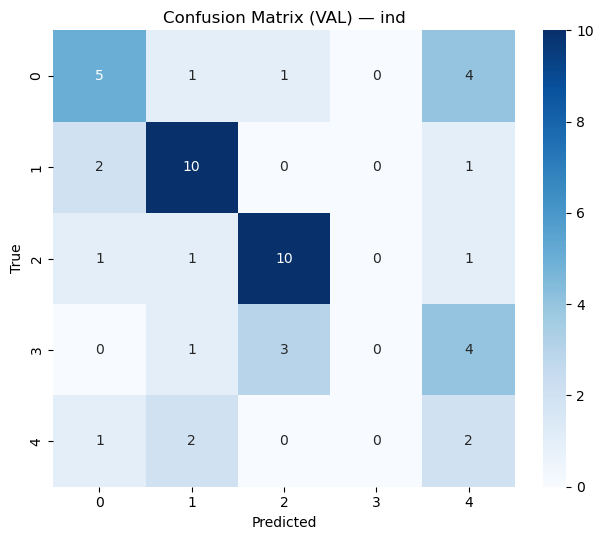


Classification Report (VAL):
               precision    recall  f1-score   support

           0     0.5556    0.4545    0.5000        11
           1     0.6667    0.7692    0.7143        13
           2     0.7143    0.7692    0.7407        13
           3     0.0000    0.0000    0.0000         8
           4     0.1667    0.4000    0.2353         5

    accuracy                         0.5400        50
   macro avg     0.4206    0.4786    0.4381        50
weighted avg     0.4979    0.5400    0.5118        50



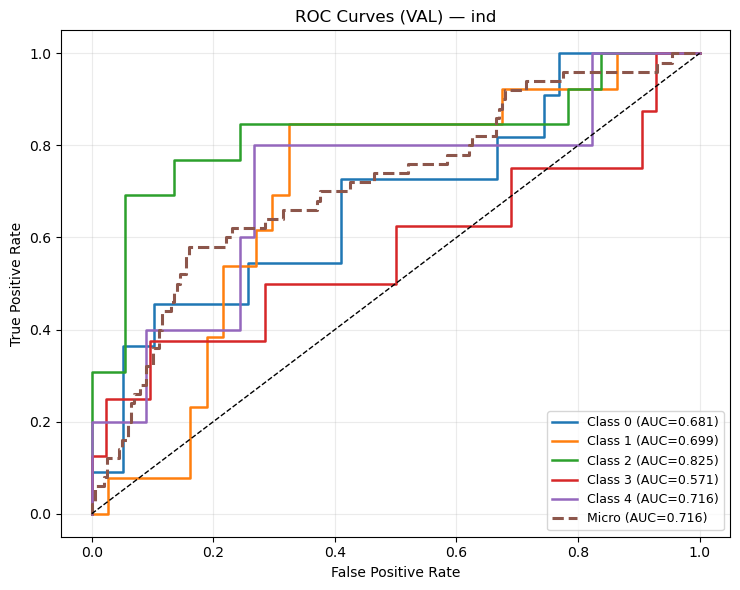


AUC-ROC (VAL): micro 0.7162 | macro 0.6983


In [11]:
def read_ids_from_dir(dir_path: str):
    return set(os.path.splitext(fn)[0] for fn in os.listdir(dir_path))

# Load + encode once
df = pd.read_csv(CSV_PATH)

# --- Split 1: Person-Independent
train_ids_A = read_ids_from_dir("Person-Independent_Split/train")
val_ids_A   = read_ids_from_dir("Person-Independent_Split/val")

res_A = run_split("ind", train_ids_A, val_ids_A)

# Person - Dependent Split

[I 2025-08-16 21:38:24,075] A new study created in memory with name: no-name-5d134f02-2b18-49be-b715-12577e53b39b



=== Running CLASSIFICATION split: dep (target: view_range_enc_dep) ===

[trial 0] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.4271, Acc=0.1806, F1=0.1804 | Val Loss=1.8844, Acc=0.1961, F1=0.0656
Epoch 02: Train Loss=1.8747, Acc=0.2174, F1=0.1845 | Val Loss=1.8339, Acc=0.1961, F1=0.0656
Epoch 03: Train Loss=1.8362, Acc=0.1706, F1=0.1631 | Val Loss=1.6408, Acc=0.1961, F1=0.0656
Epoch 04: Train Loss=1.7461, Acc=0.1806, F1=0.1748 | Val Loss=1.7657, Acc=0.1961, F1=0.0656
Epoch 05: Train Loss=1.6912, Acc=0.1873, F1=0.1827 | Val Loss=1.6825, Acc=0.1961, F1=0.0656
Epoch 06: Train Loss=1.6549, Acc=0.1906, F1=0.1826 | Val Loss=1.6556, Acc=0.1961, F1=0.0656
Epoch 07: Train Loss=1.6970, Acc=0.1639, F1=0.1618 | Val Loss=1.6524, Acc=0.1961, F1=0.0656
Epoch 08: Train Loss=1.6803, Acc=0.1739, F1=0.1480 | Val Loss=1.6271, Acc=0.1961, F1=0.0656
Epoch 09: Train Loss=1.6636, Acc=0.1672, F1=0.1544 | Val Loss=1.6211, Acc=0.1961, F1=0.0656
Epoch 10: Train Loss=1.6547, Acc=0.1940, F1=0.1606 | Val Loss=1.6612, Acc=0.2157, F1=0.0710
Epoch 11: Train Loss=1.6456, Acc=0.2074, F1=0.1932 | Val Loss=1.6364, Acc=0.1961

[I 2025-08-16 21:41:10,428] Trial 0 finished with value: 0.21568627450980393 and parameters: {'nhead': 8, 'num_layers': 3, 'lr': 0.0015751320499779737, 'weight_decay': 2.9380279387035354e-06}. Best is trial 0 with value: 0.21568627450980393.


Epoch 20: Train Loss=1.6328, Acc=0.2007, F1=0.1767 | Val Loss=1.6648, Acc=0.1961, F1=0.0656
Early stopping

[trial 1] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.3415, Acc=0.2441, F1=0.2410 | Val Loss=1.9023, Acc=0.1961, F1=0.0656
Epoch 02: Train Loss=1.8181, Acc=0.2174, F1=0.2066 | Val Loss=2.0777, Acc=0.1961, F1=0.0656
Epoch 03: Train Loss=1.7609, Acc=0.2107, F1=0.1993 | Val Loss=1.6289, Acc=0.1961, F1=0.0656
Epoch 04: Train Loss=1.7185, Acc=0.2040, F1=0.2039 | Val Loss=1.7843, Acc=0.1961, F1=0.0656
Epoch 05: Train Loss=1.7011, Acc=0.1773, F1=0.1684 | Val Loss=1.6701, Acc=0.1961, F1=0.0656
Epoch 06: Train Loss=1.6657, Acc=0.2107, F1=0.2084 | Val Loss=1.9073, Acc=0.1961, F1=0.0656
Epoch 07: Train Loss=1.7334, Acc=0.1237, F1=0.1211 | Val Loss=1.6346, Acc=0.1961, F1=0.0656
Epoch 08: Train Loss=1.6626, Acc=0.1906, F1=0.1770 | Val Loss=1.6351, Acc=0.1961, F1=0.0656
Epoch 09: Train Loss=1.6464, Acc=0.2375, F1=0.2350 | Val Loss=1.7436, Acc=0.1961, F1=0.0656
Epoch 10: Train Loss=1.7059, Acc=0.1906, F1=0.1842 | Val Loss=1.6107, Acc=0.1961, F1=0.0656


[I 2025-08-16 21:43:07,544] Trial 1 finished with value: 0.19607843137254902 and parameters: {'nhead': 4, 'num_layers': 4, 'lr': 0.0015930522616241021, 'weight_decay': 0.000133112160807369}. Best is trial 0 with value: 0.21568627450980393.


Epoch 11: Train Loss=1.6379, Acc=0.1773, F1=0.1654 | Val Loss=1.6204, Acc=0.1961, F1=0.0656
Early stopping

[trial 2] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.0099, Acc=0.2207, F1=0.2173 | Val Loss=1.6026, Acc=0.2745, F1=0.1595
Epoch 02: Train Loss=1.6308, Acc=0.2508, F1=0.2421 | Val Loss=1.6246, Acc=0.1961, F1=0.0656
Epoch 03: Train Loss=1.7323, Acc=0.2274, F1=0.2237 | Val Loss=1.5924, Acc=0.2549, F1=0.1474
Epoch 04: Train Loss=1.6798, Acc=0.2642, F1=0.2629 | Val Loss=1.7753, Acc=0.2549, F1=0.1521
Epoch 05: Train Loss=1.5858, Acc=0.2709, F1=0.2500 | Val Loss=1.6437, Acc=0.2549, F1=0.1387
Epoch 06: Train Loss=1.5429, Acc=0.2943, F1=0.2857 | Val Loss=1.5321, Acc=0.2549, F1=0.1689
Epoch 07: Train Loss=1.5359, Acc=0.3010, F1=0.2663 | Val Loss=1.5748, Acc=0.3137, F1=0.1843
Epoch 08: Train Loss=1.5624, Acc=0.2475, F1=0.2391 | Val Loss=1.6544, Acc=0.1961, F1=0.0656
Epoch 09: Train Loss=1.6683, Acc=0.2140, F1=0.1690 | Val Loss=1.6320, Acc=0.2157, F1=0.0710
Epoch 10: Train Loss=1.7442, Acc=0.1706, F1=0.1464 | Val Loss=1.6879, Acc=0.1961, F1=0.0656
Epoch 11: Train Loss=1.6548, Acc=0.1940, F1=0.1633 | Val Loss=1.6289, Acc=0.1961

[I 2025-08-16 21:46:08,396] Trial 2 finished with value: 0.3137254901960784 and parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.00026587543983272726, 'weight_decay': 3.5113563139704077e-06}. Best is trial 2 with value: 0.3137254901960784.


Epoch 17: Train Loss=1.6444, Acc=0.2107, F1=0.1576 | Val Loss=1.6215, Acc=0.1961, F1=0.0656
Early stopping

[trial 3] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.1971, Acc=0.2040, F1=0.1915 | Val Loss=1.6750, Acc=0.1961, F1=0.0656
Epoch 02: Train Loss=1.8081, Acc=0.1839, F1=0.1652 | Val Loss=1.6350, Acc=0.1961, F1=0.0656
Epoch 03: Train Loss=1.6856, Acc=0.2140, F1=0.1996 | Val Loss=1.8026, Acc=0.1961, F1=0.0656
Epoch 04: Train Loss=1.7214, Acc=0.2207, F1=0.2136 | Val Loss=1.7008, Acc=0.1961, F1=0.0656
Epoch 05: Train Loss=1.7098, Acc=0.2207, F1=0.2104 | Val Loss=1.7102, Acc=0.1961, F1=0.0656
Epoch 06: Train Loss=1.6825, Acc=0.2207, F1=0.1945 | Val Loss=1.8316, Acc=0.1961, F1=0.0656
Epoch 07: Train Loss=1.6823, Acc=0.1873, F1=0.1817 | Val Loss=1.6275, Acc=0.1961, F1=0.0656
Epoch 08: Train Loss=1.6793, Acc=0.1906, F1=0.1819 | Val Loss=1.6479, Acc=0.1961, F1=0.0656
Epoch 09: Train Loss=1.6452, Acc=0.2040, F1=0.1848 | Val Loss=1.6608, Acc=0.1961, F1=0.0656
Epoch 10: Train Loss=1.6642, Acc=0.2174, F1=0.2098 | Val Loss=1.6350, Acc=0.1961, F1=0.0656


[I 2025-08-16 21:47:41,465] Trial 3 finished with value: 0.19607843137254902 and parameters: {'nhead': 8, 'num_layers': 3, 'lr': 0.0007309539835912913, 'weight_decay': 7.4763120622522945e-06}. Best is trial 2 with value: 0.3137254901960784.


Epoch 11: Train Loss=1.6578, Acc=0.1706, F1=0.1554 | Val Loss=1.6730, Acc=0.1961, F1=0.0656
Early stopping

[trial 4] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.1925, Acc=0.2308, F1=0.2284 | Val Loss=1.9674, Acc=0.2941, F1=0.1651
Epoch 02: Train Loss=1.6603, Acc=0.3077, F1=0.3062 | Val Loss=1.5903, Acc=0.3137, F1=0.1787
Epoch 03: Train Loss=1.6517, Acc=0.2508, F1=0.2266 | Val Loss=1.6577, Acc=0.2157, F1=0.1011
Epoch 04: Train Loss=1.6951, Acc=0.2742, F1=0.2703 | Val Loss=1.6957, Acc=0.2157, F1=0.0994
Epoch 05: Train Loss=1.6069, Acc=0.2609, F1=0.2630 | Val Loss=1.5963, Acc=0.3137, F1=0.1851
Epoch 06: Train Loss=1.5498, Acc=0.2977, F1=0.2779 | Val Loss=1.6967, Acc=0.2549, F1=0.1812
Epoch 07: Train Loss=1.5773, Acc=0.2977, F1=0.2908 | Val Loss=1.5566, Acc=0.2745, F1=0.1665
Epoch 08: Train Loss=1.4926, Acc=0.3244, F1=0.3223 | Val Loss=1.4973, Acc=0.3333, F1=0.2349
Epoch 09: Train Loss=1.4419, Acc=0.2876, F1=0.2714 | Val Loss=1.5474, Acc=0.3137, F1=0.1818
Epoch 10: Train Loss=1.5051, Acc=0.2776, F1=0.2676 | Val Loss=1.5450, Acc=0.2941, F1=0.1826
Epoch 11: Train Loss=1.4406, Acc=0.3512, F1=0.3301 | Val Loss=1.6305, Acc=0.3137

[I 2025-08-16 21:49:24,109] Trial 4 finished with value: 0.3333333333333333 and parameters: {'nhead': 4, 'num_layers': 2, 'lr': 0.0005404103854647331, 'weight_decay': 2.334586407601622e-05}. Best is trial 4 with value: 0.3333333333333333.


Epoch 18: Train Loss=1.5159, Acc=0.3077, F1=0.3043 | Val Loss=1.4966, Acc=0.2941, F1=0.2047
Early stopping

[trial 5] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.5144, Acc=0.1773, F1=0.1648 | Val Loss=1.7401, Acc=0.2157, F1=0.0710
Epoch 02: Train Loss=1.7592, Acc=0.1873, F1=0.1736 | Val Loss=1.7326, Acc=0.2157, F1=0.0710
Epoch 03: Train Loss=1.7494, Acc=0.2140, F1=0.2079 | Val Loss=1.7608, Acc=0.1961, F1=0.0656
Epoch 04: Train Loss=1.7576, Acc=0.1706, F1=0.1641 | Val Loss=1.8437, Acc=0.1961, F1=0.0656
Epoch 05: Train Loss=1.7170, Acc=0.2140, F1=0.2089 | Val Loss=1.6452, Acc=0.1961, F1=0.0656
Epoch 06: Train Loss=1.6686, Acc=0.1706, F1=0.1496 | Val Loss=1.6399, Acc=0.1961, F1=0.0656
Epoch 07: Train Loss=1.6717, Acc=0.1873, F1=0.1801 | Val Loss=1.6733, Acc=0.1961, F1=0.0656
Epoch 08: Train Loss=1.6750, Acc=0.1773, F1=0.1418 | Val Loss=1.6327, Acc=0.1961, F1=0.0656
Epoch 09: Train Loss=1.6529, Acc=0.1672, F1=0.1420 | Val Loss=1.7025, Acc=0.2157, F1=0.0710
Epoch 10: Train Loss=1.6732, Acc=0.1405, F1=0.1355 | Val Loss=1.6263, Acc=0.1961, F1=0.0656


[I 2025-08-16 21:50:33,382] Trial 5 finished with value: 0.21568627450980393 and parameters: {'nhead': 4, 'num_layers': 3, 'lr': 0.0015304852121831463, 'weight_decay': 1.3783237455007196e-06}. Best is trial 4 with value: 0.3333333333333333.


Epoch 11: Train Loss=1.6687, Acc=0.1839, F1=0.1644 | Val Loss=1.6420, Acc=0.1961, F1=0.0656
Early stopping

[trial 6] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=3.5388, Acc=0.1572, F1=0.1576 | Val Loss=1.8741, Acc=0.1961, F1=0.0656
Epoch 02: Train Loss=1.8679, Acc=0.2007, F1=0.1978 | Val Loss=1.6471, Acc=0.1961, F1=0.0656
Epoch 03: Train Loss=1.6613, Acc=0.2007, F1=0.1897 | Val Loss=1.6339, Acc=0.1961, F1=0.0656
Epoch 04: Train Loss=1.6916, Acc=0.2241, F1=0.2255 | Val Loss=1.7563, Acc=0.2157, F1=0.0710
Epoch 05: Train Loss=1.6060, Acc=0.2575, F1=0.2444 | Val Loss=1.6121, Acc=0.2941, F1=0.1750
Epoch 06: Train Loss=1.5658, Acc=0.2676, F1=0.2433 | Val Loss=1.4996, Acc=0.2941, F1=0.1706
Epoch 07: Train Loss=1.5922, Acc=0.2408, F1=0.2381 | Val Loss=1.6388, Acc=0.1961, F1=0.0656
Epoch 08: Train Loss=1.7116, Acc=0.1973, F1=0.1862 | Val Loss=1.7282, Acc=0.1765, F1=0.0935
Epoch 09: Train Loss=1.6502, Acc=0.2475, F1=0.2409 | Val Loss=2.0057, Acc=0.2353, F1=0.1181
Epoch 10: Train Loss=1.6668, Acc=0.2441, F1=0.2373 | Val Loss=1.6308, Acc=0.1765, F1=0.0832
Epoch 11: Train Loss=1.6279, Acc=0.2709, F1=0.2476 | Val Loss=1.6551, Acc=0.1961

[I 2025-08-16 21:51:10,594] Trial 6 finished with value: 0.29411764705882354 and parameters: {'nhead': 4, 'num_layers': 1, 'lr': 0.007902619549708232, 'weight_decay': 0.0007886714129990489}. Best is trial 4 with value: 0.3333333333333333.


Epoch 15: Train Loss=1.5998, Acc=0.2542, F1=0.2404 | Val Loss=1.6214, Acc=0.2157, F1=0.1035
Early stopping

[trial 7] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.5197, Acc=0.2508, F1=0.2491 | Val Loss=2.1059, Acc=0.3137, F1=0.2227
Epoch 02: Train Loss=1.7330, Acc=0.2776, F1=0.2734 | Val Loss=1.5618, Acc=0.2745, F1=0.1548
Epoch 03: Train Loss=1.6322, Acc=0.2843, F1=0.2803 | Val Loss=1.5329, Acc=0.2941, F1=0.1689
Epoch 04: Train Loss=1.6407, Acc=0.2977, F1=0.2961 | Val Loss=1.7938, Acc=0.3137, F1=0.1812
Epoch 05: Train Loss=1.6377, Acc=0.2742, F1=0.2522 | Val Loss=1.7235, Acc=0.2549, F1=0.1910
Epoch 06: Train Loss=1.6088, Acc=0.2642, F1=0.2633 | Val Loss=1.6038, Acc=0.2353, F1=0.1211
Epoch 07: Train Loss=1.5832, Acc=0.2977, F1=0.2793 | Val Loss=1.5389, Acc=0.2745, F1=0.1551
Epoch 08: Train Loss=1.5489, Acc=0.2776, F1=0.2595 | Val Loss=1.5409, Acc=0.2745, F1=0.1629
Epoch 09: Train Loss=1.5080, Acc=0.2843, F1=0.2769 | Val Loss=1.5884, Acc=0.2941, F1=0.1757
Epoch 10: Train Loss=1.4593, Acc=0.3177, F1=0.2916 | Val Loss=1.5645, Acc=0.2353, F1=0.1704


[I 2025-08-16 21:51:37,818] Trial 7 finished with value: 0.3137254901960784 and parameters: {'nhead': 4, 'num_layers': 1, 'lr': 0.0023359635026261607, 'weight_decay': 2.091498132903561e-05}. Best is trial 4 with value: 0.3333333333333333.


Epoch 11: Train Loss=1.4237, Acc=0.3378, F1=0.2978 | Val Loss=1.5376, Acc=0.2941, F1=0.2282
Early stopping

[trial 8] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.6662, Acc=0.1906, F1=0.1882 | Val Loss=2.0698, Acc=0.1961, F1=0.0656
Epoch 02: Train Loss=2.0916, Acc=0.1839, F1=0.1852 | Val Loss=1.8124, Acc=0.1961, F1=0.0656
Epoch 03: Train Loss=1.7136, Acc=0.2040, F1=0.2001 | Val Loss=1.6900, Acc=0.2941, F1=0.2186
Epoch 04: Train Loss=1.5651, Acc=0.2876, F1=0.2815 | Val Loss=1.5198, Acc=0.3137, F1=0.2415
Epoch 05: Train Loss=1.5816, Acc=0.3010, F1=0.2999 | Val Loss=1.5264, Acc=0.3333, F1=0.2529
Epoch 06: Train Loss=1.5229, Acc=0.3077, F1=0.2946 | Val Loss=1.7012, Acc=0.2157, F1=0.1238
Epoch 07: Train Loss=1.4804, Acc=0.3110, F1=0.3057 | Val Loss=1.6970, Acc=0.2549, F1=0.1898
Epoch 08: Train Loss=1.4921, Acc=0.2843, F1=0.2828 | Val Loss=1.5273, Acc=0.2745, F1=0.2224
Epoch 09: Train Loss=1.4347, Acc=0.3344, F1=0.2974 | Val Loss=1.7198, Acc=0.2353, F1=0.2052
Epoch 10: Train Loss=1.4035, Acc=0.3244, F1=0.3047 | Val Loss=1.5962, Acc=0.2353, F1=0.1713
Epoch 11: Train Loss=1.3684, Acc=0.3612, F1=0.3421 | Val Loss=1.9481, Acc=0.2157

[I 2025-08-16 21:52:16,145] Trial 8 finished with value: 0.3333333333333333 and parameters: {'nhead': 8, 'num_layers': 1, 'lr': 0.006586289317583112, 'weight_decay': 5.975027999960295e-06}. Best is trial 4 with value: 0.3333333333333333.


Epoch 15: Train Loss=1.2843, Acc=0.3645, F1=0.3615 | Val Loss=2.1676, Acc=0.1373, F1=0.0890
Early stopping

[trial 9] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.4651, Acc=0.1873, F1=0.1838 | Val Loss=1.8937, Acc=0.2157, F1=0.0710
Epoch 02: Train Loss=1.7356, Acc=0.2140, F1=0.2072 | Val Loss=1.6394, Acc=0.1961, F1=0.0656
Epoch 03: Train Loss=1.7081, Acc=0.1906, F1=0.1854 | Val Loss=1.7558, Acc=0.1961, F1=0.0656
Epoch 04: Train Loss=1.7241, Acc=0.1572, F1=0.1491 | Val Loss=1.7099, Acc=0.1961, F1=0.0656
Epoch 05: Train Loss=1.7062, Acc=0.1505, F1=0.1500 | Val Loss=1.7009, Acc=0.2157, F1=0.0710
Epoch 06: Train Loss=1.7008, Acc=0.1639, F1=0.1533 | Val Loss=1.6405, Acc=0.1961, F1=0.0656
Epoch 07: Train Loss=1.6901, Acc=0.1739, F1=0.1564 | Val Loss=1.6261, Acc=0.1961, F1=0.0656
Epoch 08: Train Loss=1.6729, Acc=0.1873, F1=0.1738 | Val Loss=1.6310, Acc=0.1961, F1=0.0656
Epoch 09: Train Loss=1.6624, Acc=0.2140, F1=0.2106 | Val Loss=1.6382, Acc=0.1961, F1=0.0656
Epoch 10: Train Loss=1.6809, Acc=0.1739, F1=0.1412 | Val Loss=1.6294, Acc=0.1961, F1=0.0656


[I 2025-08-16 21:53:22,284] Trial 9 finished with value: 0.21568627450980393 and parameters: {'nhead': 4, 'num_layers': 3, 'lr': 0.0012399967836846098, 'weight_decay': 3.5856126103453987e-06}. Best is trial 4 with value: 0.3333333333333333.


Epoch 11: Train Loss=1.6486, Acc=0.2174, F1=0.1760 | Val Loss=1.6308, Acc=0.1961, F1=0.0656
Early stopping

[trial 10] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.7603, Acc=0.2542, F1=0.2527 | Val Loss=1.7236, Acc=0.2745, F1=0.1629
Epoch 02: Train Loss=1.5559, Acc=0.3311, F1=0.3308 | Val Loss=1.5547, Acc=0.2549, F1=0.1984
Epoch 03: Train Loss=1.5620, Acc=0.3344, F1=0.3304 | Val Loss=1.4909, Acc=0.3333, F1=0.3001
Epoch 04: Train Loss=1.4985, Acc=0.3378, F1=0.3336 | Val Loss=1.4423, Acc=0.3725, F1=0.3758
Epoch 05: Train Loss=1.4244, Acc=0.3612, F1=0.3608 | Val Loss=1.8217, Acc=0.3725, F1=0.2770
Epoch 06: Train Loss=1.4733, Acc=0.4348, F1=0.4340 | Val Loss=1.4802, Acc=0.3725, F1=0.3311
Epoch 07: Train Loss=1.3749, Acc=0.4080, F1=0.4087 | Val Loss=1.4811, Acc=0.3333, F1=0.2908
Epoch 08: Train Loss=1.3149, Acc=0.4582, F1=0.4516 | Val Loss=1.4956, Acc=0.2549, F1=0.2161
Epoch 09: Train Loss=1.2803, Acc=0.4716, F1=0.4640 | Val Loss=1.3704, Acc=0.4314, F1=0.4231
Epoch 10: Train Loss=1.2330, Acc=0.5385, F1=0.5338 | Val Loss=1.4760, Acc=0.2941, F1=0.2883
Epoch 11: Train Loss=1.1160, Acc=0.5652, F1=0.5646 | Val Loss=1.6726, Acc=0.3529

[I 2025-08-16 21:55:34,638] Trial 10 finished with value: 0.5294117647058824 and parameters: {'nhead': 4, 'num_layers': 2, 'lr': 0.00010353677627159794, 'weight_decay': 8.306050731972222e-05}. Best is trial 10 with value: 0.5294117647058824.


Epoch 31: Train Loss=0.0048, Acc=0.9967, F1=0.9966 | Val Loss=4.5266, Acc=0.5294, F1=0.5272
Early stopping

[trial 11] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.8253, Acc=0.2441, F1=0.2409 | Val Loss=1.6374, Acc=0.2157, F1=0.1137
Epoch 02: Train Loss=1.5937, Acc=0.3244, F1=0.3179 | Val Loss=1.6582, Acc=0.3137, F1=0.2084
Epoch 03: Train Loss=1.5184, Acc=0.3211, F1=0.3153 | Val Loss=1.6546, Acc=0.3529, F1=0.2308
Epoch 04: Train Loss=1.5175, Acc=0.3813, F1=0.3763 | Val Loss=1.5132, Acc=0.3333, F1=0.2709
Epoch 05: Train Loss=1.4953, Acc=0.3645, F1=0.3653 | Val Loss=1.4465, Acc=0.2549, F1=0.2348
Epoch 06: Train Loss=1.4035, Acc=0.3913, F1=0.3878 | Val Loss=1.4280, Acc=0.4118, F1=0.3310
Epoch 07: Train Loss=1.3997, Acc=0.4214, F1=0.4211 | Val Loss=1.4074, Acc=0.4314, F1=0.3948
Epoch 08: Train Loss=1.3549, Acc=0.4749, F1=0.4664 | Val Loss=1.6667, Acc=0.3333, F1=0.2765
Epoch 09: Train Loss=1.3833, Acc=0.4214, F1=0.4204 | Val Loss=1.3795, Acc=0.3529, F1=0.3399
Epoch 10: Train Loss=1.2457, Acc=0.4716, F1=0.4623 | Val Loss=1.5364, Acc=0.3725, F1=0.3275
Epoch 11: Train Loss=1.1942, Acc=0.5251, F1=0.5216 | Val Loss=1.6191, Acc=0.4314

[I 2025-08-16 21:58:10,309] Trial 11 finished with value: 0.5490196078431373 and parameters: {'nhead': 4, 'num_layers': 2, 'lr': 0.00010744583847151158, 'weight_decay': 8.201915027201743e-05}. Best is trial 11 with value: 0.5490196078431373.


Epoch 36: Train Loss=0.0201, Acc=0.9967, F1=0.9967 | Val Loss=4.6521, Acc=0.5294, F1=0.5067
Early stopping

[trial 12] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.7403, Acc=0.2542, F1=0.2498 | Val Loss=1.5101, Acc=0.2549, F1=0.1462
Epoch 02: Train Loss=1.5708, Acc=0.2642, F1=0.2625 | Val Loss=1.7083, Acc=0.2745, F1=0.1996
Epoch 03: Train Loss=1.5353, Acc=0.2910, F1=0.2902 | Val Loss=1.4636, Acc=0.3529, F1=0.2958
Epoch 04: Train Loss=1.4868, Acc=0.3445, F1=0.3423 | Val Loss=1.5828, Acc=0.2353, F1=0.1227
Epoch 05: Train Loss=1.4779, Acc=0.3411, F1=0.3345 | Val Loss=1.4904, Acc=0.3529, F1=0.3145
Epoch 06: Train Loss=1.4253, Acc=0.3311, F1=0.3274 | Val Loss=1.4283, Acc=0.3137, F1=0.2704
Epoch 07: Train Loss=1.3563, Acc=0.4013, F1=0.3965 | Val Loss=1.4935, Acc=0.3529, F1=0.3175
Epoch 08: Train Loss=1.3409, Acc=0.4515, F1=0.4506 | Val Loss=1.5073, Acc=0.4118, F1=0.3509
Epoch 09: Train Loss=1.3521, Acc=0.4214, F1=0.4201 | Val Loss=1.5202, Acc=0.4118, F1=0.3849
Epoch 10: Train Loss=1.2082, Acc=0.5151, F1=0.5110 | Val Loss=1.5069, Acc=0.3529, F1=0.3280
Epoch 11: Train Loss=1.1862, Acc=0.4916, F1=0.4889 | Val Loss=1.5163, Acc=0.3922

[I 2025-08-16 21:59:59,833] Trial 12 finished with value: 0.47058823529411764 and parameters: {'nhead': 4, 'num_layers': 2, 'lr': 0.00010752119651179309, 'weight_decay': 0.0001234433488463974}. Best is trial 11 with value: 0.5490196078431373.


Epoch 25: Train Loss=0.1472, Acc=0.9532, F1=0.9531 | Val Loss=4.7224, Acc=0.3725, F1=0.3810
Early stopping

[trial 13] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.7090, Acc=0.2676, F1=0.2665 | Val Loss=1.6211, Acc=0.3529, F1=0.2731
Epoch 02: Train Loss=1.6040, Acc=0.2977, F1=0.2949 | Val Loss=1.4585, Acc=0.3333, F1=0.2823
Epoch 03: Train Loss=1.4819, Acc=0.3378, F1=0.3293 | Val Loss=1.4740, Acc=0.4118, F1=0.3684
Epoch 04: Train Loss=1.5226, Acc=0.3077, F1=0.3053 | Val Loss=1.5504, Acc=0.3137, F1=0.2298
Epoch 05: Train Loss=1.4839, Acc=0.3579, F1=0.3485 | Val Loss=1.5649, Acc=0.2353, F1=0.1590
Epoch 06: Train Loss=1.4589, Acc=0.3512, F1=0.3526 | Val Loss=1.4376, Acc=0.3137, F1=0.2904
Epoch 07: Train Loss=1.4205, Acc=0.3746, F1=0.3691 | Val Loss=1.4846, Acc=0.3333, F1=0.2764
Epoch 08: Train Loss=1.4093, Acc=0.3946, F1=0.3846 | Val Loss=1.3929, Acc=0.3333, F1=0.3166
Epoch 09: Train Loss=1.3323, Acc=0.4381, F1=0.4357 | Val Loss=1.4663, Acc=0.2941, F1=0.2829
Epoch 10: Train Loss=1.2268, Acc=0.5050, F1=0.4991 | Val Loss=1.4389, Acc=0.4314, F1=0.3715
Epoch 11: Train Loss=1.1158, Acc=0.5251, F1=0.5236 | Val Loss=1.5071, Acc=0.2941

[I 2025-08-16 22:02:15,621] Trial 13 finished with value: 0.5294117647058824 and parameters: {'nhead': 4, 'num_layers': 2, 'lr': 0.00011531894892803138, 'weight_decay': 0.00011437759657785997}. Best is trial 11 with value: 0.5490196078431373.


Epoch 31: Train Loss=0.0413, Acc=0.9799, F1=0.9800 | Val Loss=4.8015, Acc=0.4314, F1=0.4038
Early stopping

[trial 14] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.8847, Acc=0.2609, F1=0.2536 | Val Loss=1.8439, Acc=0.2157, F1=0.0977
Epoch 02: Train Loss=1.6334, Acc=0.2742, F1=0.2682 | Val Loss=1.9299, Acc=0.2157, F1=0.0721
Epoch 03: Train Loss=1.5955, Acc=0.2943, F1=0.2911 | Val Loss=1.4789, Acc=0.2941, F1=0.2543
Epoch 04: Train Loss=1.5411, Acc=0.2508, F1=0.2465 | Val Loss=1.5392, Acc=0.2353, F1=0.1920
Epoch 05: Train Loss=1.4575, Acc=0.3579, F1=0.3570 | Val Loss=1.4533, Acc=0.3725, F1=0.3235
Epoch 06: Train Loss=1.4594, Acc=0.3177, F1=0.3142 | Val Loss=1.4596, Acc=0.3137, F1=0.2720
Epoch 07: Train Loss=1.4252, Acc=0.3445, F1=0.3397 | Val Loss=1.4407, Acc=0.3725, F1=0.3032
Epoch 08: Train Loss=1.4069, Acc=0.3712, F1=0.3675 | Val Loss=1.4172, Acc=0.4118, F1=0.3706
Epoch 09: Train Loss=1.4245, Acc=0.3645, F1=0.3588 | Val Loss=1.3883, Acc=0.3725, F1=0.3698
Epoch 10: Train Loss=1.3617, Acc=0.3846, F1=0.3778 | Val Loss=1.5151, Acc=0.3725, F1=0.2824
Epoch 11: Train Loss=1.3751, Acc=0.4214, F1=0.4151 | Val Loss=1.5150, Acc=0.3333

[I 2025-08-16 22:03:32,822] Trial 14 finished with value: 0.4117647058823529 and parameters: {'nhead': 4, 'num_layers': 2, 'lr': 0.0002583605014014802, 'weight_decay': 0.00037372800583511184}. Best is trial 11 with value: 0.5490196078431373.


Epoch 18: Train Loss=1.0474, Acc=0.5385, F1=0.5361 | Val Loss=1.4693, Acc=0.2941, F1=0.2909
Early stopping

[trial 15] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.9805, Acc=0.2876, F1=0.2856 | Val Loss=1.6373, Acc=0.3529, F1=0.2296
Epoch 02: Train Loss=1.5525, Acc=0.3043, F1=0.3054 | Val Loss=1.4985, Acc=0.2745, F1=0.1849
Epoch 03: Train Loss=1.5295, Acc=0.3211, F1=0.3094 | Val Loss=1.4932, Acc=0.3137, F1=0.1857
Epoch 04: Train Loss=1.5132, Acc=0.3378, F1=0.3308 | Val Loss=1.5446, Acc=0.3137, F1=0.2461
Epoch 05: Train Loss=1.4578, Acc=0.3746, F1=0.3747 | Val Loss=1.5161, Acc=0.3333, F1=0.2619
Epoch 06: Train Loss=1.4431, Acc=0.3579, F1=0.3581 | Val Loss=1.5764, Acc=0.3529, F1=0.3106
Epoch 07: Train Loss=1.3665, Acc=0.3880, F1=0.3836 | Val Loss=1.5406, Acc=0.3725, F1=0.3155
Epoch 08: Train Loss=1.2704, Acc=0.4348, F1=0.4347 | Val Loss=1.4784, Acc=0.3529, F1=0.2897
Epoch 09: Train Loss=1.1779, Acc=0.5050, F1=0.5034 | Val Loss=1.5909, Acc=0.3333, F1=0.2792
Epoch 10: Train Loss=1.1456, Acc=0.5385, F1=0.5378 | Val Loss=1.7688, Acc=0.3725, F1=0.3611
Epoch 11: Train Loss=1.0895, Acc=0.5585, F1=0.5572 | Val Loss=1.6598, Acc=0.4118

[I 2025-08-16 22:06:10,802] Trial 15 finished with value: 0.5294117647058824 and parameters: {'nhead': 4, 'num_layers': 2, 'lr': 0.00022545502715832472, 'weight_decay': 6.541822415477904e-05}. Best is trial 11 with value: 0.5490196078431373.


Epoch 37: Train Loss=0.0243, Acc=0.9900, F1=0.9899 | Val Loss=6.0436, Acc=0.3529, F1=0.3333
Early stopping

[trial 16] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.7539, Acc=0.2408, F1=0.2400 | Val Loss=1.5658, Acc=0.3333, F1=0.2924
Epoch 02: Train Loss=1.5428, Acc=0.2977, F1=0.2973 | Val Loss=1.5143, Acc=0.3725, F1=0.2864
Epoch 03: Train Loss=1.4965, Acc=0.3411, F1=0.3315 | Val Loss=1.5441, Acc=0.2941, F1=0.1785
Epoch 04: Train Loss=1.4466, Acc=0.3679, F1=0.3646 | Val Loss=1.5545, Acc=0.2745, F1=0.1599
Epoch 05: Train Loss=1.4096, Acc=0.3813, F1=0.3785 | Val Loss=1.4481, Acc=0.3529, F1=0.2992
Epoch 06: Train Loss=1.3416, Acc=0.4013, F1=0.4021 | Val Loss=1.4215, Acc=0.3725, F1=0.3309
Epoch 07: Train Loss=1.2656, Acc=0.4716, F1=0.4673 | Val Loss=1.4632, Acc=0.3922, F1=0.3520
Epoch 08: Train Loss=1.2387, Acc=0.4515, F1=0.4478 | Val Loss=1.4394, Acc=0.3725, F1=0.3392
Epoch 09: Train Loss=1.1820, Acc=0.5184, F1=0.5190 | Val Loss=1.4239, Acc=0.4314, F1=0.4125
Epoch 10: Train Loss=1.0780, Acc=0.5753, F1=0.5706 | Val Loss=1.5871, Acc=0.3922, F1=0.3624
Epoch 11: Train Loss=1.0027, Acc=0.6087, F1=0.6059 | Val Loss=1.4256, Acc=0.4314

[I 2025-08-16 22:07:26,115] Trial 16 finished with value: 0.5098039215686274 and parameters: {'nhead': 4, 'num_layers': 1, 'lr': 0.000163933989301113, 'weight_decay': 4.565594045445848e-05}. Best is trial 11 with value: 0.5490196078431373.


Epoch 30: Train Loss=0.0100, Acc=0.9933, F1=0.9934 | Val Loss=4.6522, Acc=0.4706, F1=0.4603
Early stopping

[trial 17] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.0479, Acc=0.2977, F1=0.2983 | Val Loss=1.5824, Acc=0.3529, F1=0.2022
Epoch 02: Train Loss=1.6811, Acc=0.2876, F1=0.2854 | Val Loss=1.5993, Acc=0.3137, F1=0.1877
Epoch 03: Train Loss=1.5858, Acc=0.2676, F1=0.2664 | Val Loss=1.6329, Acc=0.2941, F1=0.2533
Epoch 04: Train Loss=1.5503, Acc=0.2843, F1=0.2783 | Val Loss=1.4825, Acc=0.3137, F1=0.2409
Epoch 05: Train Loss=1.5785, Acc=0.3077, F1=0.2984 | Val Loss=1.5009, Acc=0.2941, F1=0.2330
Epoch 06: Train Loss=1.5053, Acc=0.3344, F1=0.3285 | Val Loss=1.5992, Acc=0.1961, F1=0.1704
Epoch 07: Train Loss=1.4957, Acc=0.3110, F1=0.3001 | Val Loss=1.4087, Acc=0.3725, F1=0.3731
Epoch 08: Train Loss=1.4440, Acc=0.3445, F1=0.3441 | Val Loss=1.5142, Acc=0.2941, F1=0.1789
Epoch 09: Train Loss=1.4367, Acc=0.3344, F1=0.3302 | Val Loss=1.4108, Acc=0.3725, F1=0.3108
Epoch 10: Train Loss=1.4056, Acc=0.3846, F1=0.3621 | Val Loss=1.4996, Acc=0.3137, F1=0.2374
Epoch 11: Train Loss=1.4146, Acc=0.3712, F1=0.3592 | Val Loss=1.4452, Acc=0.3922

[I 2025-08-16 22:09:45,830] Trial 17 finished with value: 0.5098039215686274 and parameters: {'nhead': 4, 'num_layers': 2, 'lr': 0.0004424521231538716, 'weight_decay': 0.0002556416830707334}. Best is trial 11 with value: 0.5490196078431373.


Epoch 33: Train Loss=0.5023, Acc=0.8194, F1=0.8195 | Val Loss=2.9215, Acc=0.3725, F1=0.3010
Early stopping

[trial 18] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.4791, Acc=0.1873, F1=0.1860 | Val Loss=2.3252, Acc=0.2157, F1=0.0710
Epoch 02: Train Loss=1.8586, Acc=0.2007, F1=0.1938 | Val Loss=1.7607, Acc=0.1961, F1=0.0656
Epoch 03: Train Loss=1.8595, Acc=0.1739, F1=0.1660 | Val Loss=1.6485, Acc=0.2157, F1=0.0710
Epoch 04: Train Loss=1.7219, Acc=0.1906, F1=0.1895 | Val Loss=1.6365, Acc=0.1961, F1=0.0656
Epoch 05: Train Loss=1.6644, Acc=0.1873, F1=0.1784 | Val Loss=1.6148, Acc=0.1961, F1=0.0656
Epoch 06: Train Loss=1.7200, Acc=0.1906, F1=0.1861 | Val Loss=1.6986, Acc=0.1961, F1=0.0656
Epoch 07: Train Loss=1.6485, Acc=0.1940, F1=0.1685 | Val Loss=1.6112, Acc=0.1961, F1=0.0656
Epoch 08: Train Loss=1.6234, Acc=0.2241, F1=0.2189 | Val Loss=1.6151, Acc=0.2157, F1=0.0710
Epoch 09: Train Loss=1.6312, Acc=0.1940, F1=0.1762 | Val Loss=1.6206, Acc=0.1961, F1=0.0656
Epoch 10: Train Loss=1.6237, Acc=0.1973, F1=0.1855 | Val Loss=1.6347, Acc=0.1961, F1=0.0656


[I 2025-08-16 22:10:54,160] Trial 18 finished with value: 0.21568627450980393 and parameters: {'nhead': 8, 'num_layers': 3, 'lr': 0.0037827652380096233, 'weight_decay': 1.24711681871665e-05}. Best is trial 11 with value: 0.5490196078431373.


Epoch 11: Train Loss=1.6231, Acc=0.1973, F1=0.1620 | Val Loss=1.6437, Acc=0.1961, F1=0.0656
Early stopping

[trial 19] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.9018, Acc=0.2475, F1=0.2451 | Val Loss=1.5127, Acc=0.3922, F1=0.3231
Epoch 02: Train Loss=1.5362, Acc=0.3478, F1=0.3439 | Val Loss=1.5826, Acc=0.2745, F1=0.2512
Epoch 03: Train Loss=1.4975, Acc=0.3244, F1=0.3195 | Val Loss=1.4618, Acc=0.4118, F1=0.3523
Epoch 04: Train Loss=1.4812, Acc=0.3278, F1=0.3259 | Val Loss=1.4647, Acc=0.3922, F1=0.2937
Epoch 05: Train Loss=1.4493, Acc=0.3411, F1=0.3271 | Val Loss=1.5996, Acc=0.2549, F1=0.1514
Epoch 06: Train Loss=1.4414, Acc=0.3579, F1=0.3592 | Val Loss=1.4733, Acc=0.3333, F1=0.2493
Epoch 07: Train Loss=1.4111, Acc=0.3880, F1=0.3733 | Val Loss=1.4386, Acc=0.3529, F1=0.3283
Epoch 08: Train Loss=1.3829, Acc=0.4013, F1=0.3989 | Val Loss=1.4720, Acc=0.2941, F1=0.2008
Epoch 09: Train Loss=1.3724, Acc=0.3679, F1=0.3634 | Val Loss=1.4566, Acc=0.3529, F1=0.3033
Epoch 10: Train Loss=1.4044, Acc=0.3712, F1=0.3714 | Val Loss=1.3923, Acc=0.3333, F1=0.3254
Epoch 11: Train Loss=1.3612, Acc=0.4147, F1=0.4093 | Val Loss=1.4319, Acc=0.4118

[I 2025-08-16 22:11:26,258] Trial 19 finished with value: 0.4117647058823529 and parameters: {'nhead': 4, 'num_layers': 1, 'lr': 0.00041359362575230096, 'weight_decay': 0.0009728613904848122}. Best is trial 11 with value: 0.5490196078431373.


Epoch 13: Train Loss=1.3547, Acc=0.4047, F1=0.4013 | Val Loss=1.4051, Acc=0.3137, F1=0.2991
Early stopping

[trial 20] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.7680, Acc=0.2943, F1=0.2914 | Val Loss=1.6818, Acc=0.2941, F1=0.1937
Epoch 02: Train Loss=1.5716, Acc=0.3144, F1=0.3126 | Val Loss=1.5485, Acc=0.3922, F1=0.3128
Epoch 03: Train Loss=1.4902, Acc=0.3579, F1=0.3532 | Val Loss=1.5599, Acc=0.3333, F1=0.2450
Epoch 04: Train Loss=1.5289, Acc=0.3043, F1=0.3011 | Val Loss=1.5844, Acc=0.2549, F1=0.1973
Epoch 05: Train Loss=1.5090, Acc=0.3110, F1=0.3087 | Val Loss=1.4727, Acc=0.3137, F1=0.3208
Epoch 06: Train Loss=1.4525, Acc=0.3846, F1=0.3737 | Val Loss=1.5189, Acc=0.3333, F1=0.2361
Epoch 07: Train Loss=1.4293, Acc=0.4013, F1=0.3978 | Val Loss=1.4860, Acc=0.3922, F1=0.3327
Epoch 08: Train Loss=1.4114, Acc=0.3746, F1=0.3651 | Val Loss=1.4375, Acc=0.3725, F1=0.3421
Epoch 09: Train Loss=1.4460, Acc=0.3445, F1=0.3444 | Val Loss=1.4544, Acc=0.3333, F1=0.3042
Epoch 10: Train Loss=1.3622, Acc=0.3980, F1=0.3975 | Val Loss=1.5035, Acc=0.3529, F1=0.2606
Epoch 11: Train Loss=1.3186, Acc=0.4114, F1=0.4046 | Val Loss=1.4300, Acc=0.3137

[I 2025-08-16 22:13:30,530] Trial 20 finished with value: 0.49019607843137253 and parameters: {'nhead': 4, 'num_layers': 2, 'lr': 0.00013953416755976746, 'weight_decay': 0.0002836689484186475}. Best is trial 11 with value: 0.5490196078431373.


Epoch 29: Train Loss=0.1873, Acc=0.9398, F1=0.9399 | Val Loss=3.3258, Acc=0.4118, F1=0.3917
Early stopping

[trial 21] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.7177, Acc=0.3278, F1=0.3248 | Val Loss=1.6008, Acc=0.3137, F1=0.2090
Epoch 02: Train Loss=1.5589, Acc=0.3043, F1=0.3020 | Val Loss=1.6057, Acc=0.2745, F1=0.1580
Epoch 03: Train Loss=1.5259, Acc=0.3278, F1=0.3201 | Val Loss=1.5798, Acc=0.2941, F1=0.1685
Epoch 04: Train Loss=1.4752, Acc=0.3344, F1=0.3281 | Val Loss=1.4663, Acc=0.3529, F1=0.3189
Epoch 05: Train Loss=1.4956, Acc=0.3545, F1=0.3515 | Val Loss=1.4525, Acc=0.3333, F1=0.2792
Epoch 06: Train Loss=1.4394, Acc=0.3579, F1=0.3563 | Val Loss=1.4531, Acc=0.3137, F1=0.2335
Epoch 07: Train Loss=1.4007, Acc=0.3913, F1=0.3915 | Val Loss=1.6243, Acc=0.3725, F1=0.2885
Epoch 08: Train Loss=1.4311, Acc=0.3746, F1=0.3699 | Val Loss=1.4493, Acc=0.3922, F1=0.3752
Epoch 09: Train Loss=1.2605, Acc=0.4482, F1=0.4393 | Val Loss=1.4493, Acc=0.4706, F1=0.3981
Epoch 10: Train Loss=1.2099, Acc=0.5151, F1=0.5146 | Val Loss=1.3501, Acc=0.3922, F1=0.3666
Epoch 11: Train Loss=1.1335, Acc=0.5585, F1=0.5500 | Val Loss=1.5329, Acc=0.3333

[I 2025-08-16 22:15:53,723] Trial 21 finished with value: 0.5686274509803921 and parameters: {'nhead': 4, 'num_layers': 2, 'lr': 0.00010434959787802714, 'weight_decay': 9.753615006446377e-05}. Best is trial 21 with value: 0.5686274509803921.


Epoch 33: Train Loss=0.0510, Acc=0.9866, F1=0.9866 | Val Loss=3.7077, Acc=0.4706, F1=0.4696
Early stopping

[trial 22] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.8595, Acc=0.2809, F1=0.2811 | Val Loss=1.7523, Acc=0.2549, F1=0.1867
Epoch 02: Train Loss=1.6416, Acc=0.3311, F1=0.3287 | Val Loss=1.7572, Acc=0.3333, F1=0.1924
Epoch 03: Train Loss=1.5339, Acc=0.3579, F1=0.3582 | Val Loss=1.5650, Acc=0.3333, F1=0.2543
Epoch 04: Train Loss=1.5617, Acc=0.3043, F1=0.3027 | Val Loss=1.5530, Acc=0.2549, F1=0.1463
Epoch 05: Train Loss=1.4303, Acc=0.3712, F1=0.3543 | Val Loss=1.5365, Acc=0.3529, F1=0.3000
Epoch 06: Train Loss=1.4411, Acc=0.3980, F1=0.3977 | Val Loss=1.5153, Acc=0.3529, F1=0.2493
Epoch 07: Train Loss=1.3623, Acc=0.4114, F1=0.4066 | Val Loss=1.4677, Acc=0.3529, F1=0.3304
Epoch 08: Train Loss=1.3418, Acc=0.4214, F1=0.4178 | Val Loss=1.4352, Acc=0.4118, F1=0.3893
Epoch 09: Train Loss=1.2424, Acc=0.4916, F1=0.4889 | Val Loss=1.4692, Acc=0.3529, F1=0.3304
Epoch 10: Train Loss=1.1203, Acc=0.5585, F1=0.5581 | Val Loss=1.4054, Acc=0.4314, F1=0.4078
Epoch 11: Train Loss=1.0156, Acc=0.5786, F1=0.5782 | Val Loss=1.5197, Acc=0.4510

[I 2025-08-16 22:17:37,644] Trial 22 finished with value: 0.49019607843137253 and parameters: {'nhead': 4, 'num_layers': 2, 'lr': 0.00017320214282304762, 'weight_decay': 6.144906551352695e-05}. Best is trial 21 with value: 0.5686274509803921.


Epoch 24: Train Loss=0.0293, Acc=0.9900, F1=0.9899 | Val Loss=4.5415, Acc=0.4118, F1=0.3983
Early stopping

[trial 23] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.7971, Acc=0.2776, F1=0.2768 | Val Loss=1.6315, Acc=0.2549, F1=0.1706
Epoch 02: Train Loss=1.5805, Acc=0.2843, F1=0.2814 | Val Loss=1.5069, Acc=0.3725, F1=0.3103
Epoch 03: Train Loss=1.5109, Acc=0.3177, F1=0.3124 | Val Loss=1.4777, Acc=0.3333, F1=0.2215
Epoch 04: Train Loss=1.4992, Acc=0.3445, F1=0.3423 | Val Loss=1.7239, Acc=0.2941, F1=0.2075
Epoch 05: Train Loss=1.4824, Acc=0.3545, F1=0.3499 | Val Loss=1.5217, Acc=0.2353, F1=0.2086
Epoch 06: Train Loss=1.4222, Acc=0.3411, F1=0.3395 | Val Loss=1.3997, Acc=0.3922, F1=0.3804
Epoch 07: Train Loss=1.3814, Acc=0.3779, F1=0.3788 | Val Loss=1.4913, Acc=0.3137, F1=0.2316
Epoch 08: Train Loss=1.3302, Acc=0.4615, F1=0.4615 | Val Loss=1.4450, Acc=0.3333, F1=0.2632
Epoch 09: Train Loss=1.3002, Acc=0.4515, F1=0.4487 | Val Loss=1.4017, Acc=0.3725, F1=0.3735
Epoch 10: Train Loss=1.1759, Acc=0.5452, F1=0.5425 | Val Loss=1.4728, Acc=0.3529, F1=0.2953
Epoch 11: Train Loss=1.0513, Acc=0.5786, F1=0.5746 | Val Loss=1.4600, Acc=0.3922

[I 2025-08-16 22:19:31,023] Trial 23 finished with value: 0.43137254901960786 and parameters: {'nhead': 4, 'num_layers': 2, 'lr': 0.00010052410334227605, 'weight_decay': 3.6334054481525195e-05}. Best is trial 21 with value: 0.5686274509803921.


Epoch 26: Train Loss=0.0243, Acc=0.9933, F1=0.9933 | Val Loss=4.9410, Acc=0.3922, F1=0.3703
Early stopping

[trial 24] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.0857, Acc=0.2375, F1=0.2389 | Val Loss=1.8363, Acc=0.1961, F1=0.0656
Epoch 02: Train Loss=1.6349, Acc=0.2742, F1=0.2615 | Val Loss=1.6699, Acc=0.2353, F1=0.1248
Epoch 03: Train Loss=1.6174, Acc=0.2241, F1=0.2068 | Val Loss=1.5229, Acc=0.3529, F1=0.2300
Epoch 04: Train Loss=1.6137, Acc=0.2876, F1=0.2877 | Val Loss=1.5718, Acc=0.1961, F1=0.0656
Epoch 05: Train Loss=1.5742, Acc=0.2542, F1=0.2510 | Val Loss=1.6213, Acc=0.1961, F1=0.0656
Epoch 06: Train Loss=1.5495, Acc=0.3077, F1=0.3088 | Val Loss=1.5308, Acc=0.3137, F1=0.2331
Epoch 07: Train Loss=1.6159, Acc=0.2140, F1=0.2097 | Val Loss=1.5263, Acc=0.2353, F1=0.1712
Epoch 08: Train Loss=1.5197, Acc=0.3445, F1=0.3363 | Val Loss=1.5583, Acc=0.3137, F1=0.1812
Epoch 09: Train Loss=1.5020, Acc=0.3077, F1=0.2816 | Val Loss=1.4686, Acc=0.3137, F1=0.2087
Epoch 10: Train Loss=1.4975, Acc=0.3344, F1=0.2617 | Val Loss=1.4684, Acc=0.2941, F1=0.1823
Epoch 11: Train Loss=1.5030, Acc=0.2843, F1=0.2812 | Val Loss=1.4917, Acc=0.2745

[I 2025-08-16 22:20:52,363] Trial 24 finished with value: 0.35294117647058826 and parameters: {'nhead': 4, 'num_layers': 3, 'lr': 0.00032367871286896876, 'weight_decay': 7.751334024424333e-05}. Best is trial 21 with value: 0.5686274509803921.


Epoch 13: Train Loss=1.5012, Acc=0.2575, F1=0.2476 | Val Loss=1.4755, Acc=0.3333, F1=0.1932
Early stopping

[trial 25] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.8458, Acc=0.2676, F1=0.2699 | Val Loss=1.7006, Acc=0.2353, F1=0.1227
Epoch 02: Train Loss=1.5971, Acc=0.2776, F1=0.2773 | Val Loss=1.6256, Acc=0.2353, F1=0.1696
Epoch 03: Train Loss=1.5554, Acc=0.3043, F1=0.2985 | Val Loss=1.4877, Acc=0.2941, F1=0.2612
Epoch 04: Train Loss=1.4827, Acc=0.3211, F1=0.3186 | Val Loss=1.6266, Acc=0.3137, F1=0.1877
Epoch 05: Train Loss=1.4682, Acc=0.3344, F1=0.3258 | Val Loss=1.5277, Acc=0.2941, F1=0.2104
Epoch 06: Train Loss=1.4299, Acc=0.3679, F1=0.3616 | Val Loss=1.4201, Acc=0.3725, F1=0.3420
Epoch 07: Train Loss=1.3951, Acc=0.3645, F1=0.3516 | Val Loss=1.4840, Acc=0.3725, F1=0.3257
Epoch 08: Train Loss=1.3297, Acc=0.4147, F1=0.4105 | Val Loss=1.5292, Acc=0.3333, F1=0.3104
Epoch 09: Train Loss=1.3101, Acc=0.4348, F1=0.4304 | Val Loss=1.3739, Acc=0.3725, F1=0.3585
Epoch 10: Train Loss=1.2322, Acc=0.4849, F1=0.4823 | Val Loss=1.5441, Acc=0.3529, F1=0.3175
Epoch 11: Train Loss=1.1691, Acc=0.5050, F1=0.5031 | Val Loss=1.4267, Acc=0.4118

[I 2025-08-16 22:23:20,983] Trial 25 finished with value: 0.5490196078431373 and parameters: {'nhead': 4, 'num_layers': 2, 'lr': 0.00020301680804382034, 'weight_decay': 0.00016307267195726492}. Best is trial 21 with value: 0.5686274509803921.


Epoch 34: Train Loss=0.0467, Acc=0.9866, F1=0.9867 | Val Loss=4.6528, Acc=0.3922, F1=0.3899
Early stopping

[trial 26] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.8187, Acc=0.2776, F1=0.2756 | Val Loss=1.5476, Acc=0.3333, F1=0.2801
Epoch 02: Train Loss=1.5289, Acc=0.3545, F1=0.3483 | Val Loss=1.4333, Acc=0.3137, F1=0.2851
Epoch 03: Train Loss=1.5000, Acc=0.3779, F1=0.3754 | Val Loss=1.6202, Acc=0.3137, F1=0.2093
Epoch 04: Train Loss=1.4311, Acc=0.3645, F1=0.3649 | Val Loss=1.4925, Acc=0.3529, F1=0.2721
Epoch 05: Train Loss=1.3705, Acc=0.3946, F1=0.3932 | Val Loss=1.4650, Acc=0.3333, F1=0.2884
Epoch 06: Train Loss=1.3628, Acc=0.3813, F1=0.3819 | Val Loss=1.4969, Acc=0.3137, F1=0.2773
Epoch 07: Train Loss=1.3160, Acc=0.4247, F1=0.4217 | Val Loss=1.5812, Acc=0.2941, F1=0.2373
Epoch 08: Train Loss=1.2658, Acc=0.4749, F1=0.4738 | Val Loss=1.4271, Acc=0.3333, F1=0.3088
Epoch 09: Train Loss=1.2197, Acc=0.4849, F1=0.4846 | Val Loss=1.4452, Acc=0.3725, F1=0.3546
Epoch 10: Train Loss=1.1520, Acc=0.5485, F1=0.5472 | Val Loss=1.4607, Acc=0.4706, F1=0.4456
Epoch 11: Train Loss=1.0791, Acc=0.5819, F1=0.5811 | Val Loss=1.6136, Acc=0.4314

[I 2025-08-16 22:24:39,364] Trial 26 finished with value: 0.5490196078431373 and parameters: {'nhead': 8, 'num_layers': 1, 'lr': 0.00019072713147606145, 'weight_decay': 0.00015739304768163162}. Best is trial 21 with value: 0.5686274509803921.


Epoch 30: Train Loss=0.0618, Acc=0.9799, F1=0.9799 | Val Loss=4.4398, Acc=0.4510, F1=0.4413
Early stopping

[trial 27] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.3299, Acc=0.2174, F1=0.2143 | Val Loss=1.7884, Acc=0.2745, F1=0.1562
Epoch 02: Train Loss=1.7240, Acc=0.2174, F1=0.2104 | Val Loss=1.6196, Acc=0.2941, F1=0.1667
Epoch 03: Train Loss=1.6501, Acc=0.2375, F1=0.2284 | Val Loss=1.5516, Acc=0.2941, F1=0.2446
Epoch 04: Train Loss=1.6250, Acc=0.2642, F1=0.2613 | Val Loss=1.4438, Acc=0.3922, F1=0.2858
Epoch 05: Train Loss=1.6040, Acc=0.2441, F1=0.2351 | Val Loss=1.6234, Acc=0.2353, F1=0.1085
Epoch 06: Train Loss=1.6032, Acc=0.2776, F1=0.2766 | Val Loss=1.4856, Acc=0.2941, F1=0.1652
Epoch 07: Train Loss=1.5422, Acc=0.3545, F1=0.3536 | Val Loss=1.6149, Acc=0.2941, F1=0.1694
Epoch 08: Train Loss=1.5751, Acc=0.2876, F1=0.2807 | Val Loss=1.4925, Acc=0.2745, F1=0.1852
Epoch 09: Train Loss=1.5229, Acc=0.2575, F1=0.2311 | Val Loss=1.5600, Acc=0.2745, F1=0.1584
Epoch 10: Train Loss=1.5068, Acc=0.2843, F1=0.2573 | Val Loss=1.4872, Acc=0.3725, F1=0.3503
Epoch 11: Train Loss=1.5044, Acc=0.2977, F1=0.2928 | Val Loss=1.4594, Acc=0.3529

[I 2025-08-16 22:25:39,414] Trial 27 finished with value: 0.39215686274509803 and parameters: {'nhead': 4, 'num_layers': 2, 'lr': 0.0006644311640426634, 'weight_decay': 0.0005887057869447707}. Best is trial 21 with value: 0.5686274509803921.


Epoch 14: Train Loss=1.4993, Acc=0.3110, F1=0.2521 | Val Loss=1.5310, Acc=0.3922, F1=0.3464
Early stopping

[trial 28] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=1.9844, Acc=0.2575, F1=0.2569 | Val Loss=1.6324, Acc=0.2353, F1=0.1880
Epoch 02: Train Loss=1.6019, Acc=0.2843, F1=0.2831 | Val Loss=1.5879, Acc=0.2549, F1=0.1492
Epoch 03: Train Loss=1.5442, Acc=0.3177, F1=0.3177 | Val Loss=1.4603, Acc=0.3922, F1=0.2751
Epoch 04: Train Loss=1.5227, Acc=0.2943, F1=0.2826 | Val Loss=1.5675, Acc=0.2549, F1=0.1867
Epoch 05: Train Loss=1.5892, Acc=0.2943, F1=0.2928 | Val Loss=1.4814, Acc=0.3137, F1=0.2241
Epoch 06: Train Loss=1.5024, Acc=0.3344, F1=0.3322 | Val Loss=1.4629, Acc=0.3137, F1=0.2559
Epoch 07: Train Loss=1.4651, Acc=0.3645, F1=0.3602 | Val Loss=1.6840, Acc=0.2941, F1=0.1645
Epoch 08: Train Loss=1.5240, Acc=0.3110, F1=0.3038 | Val Loss=1.5117, Acc=0.3333, F1=0.2361
Epoch 09: Train Loss=1.4602, Acc=0.3512, F1=0.3371 | Val Loss=1.4120, Acc=0.2941, F1=0.2749
Epoch 10: Train Loss=1.4415, Acc=0.3645, F1=0.3506 | Val Loss=1.5878, Acc=0.3333, F1=0.3343
Epoch 11: Train Loss=1.4248, Acc=0.3579, F1=0.3467 | Val Loss=1.4879, Acc=0.2549

[I 2025-08-16 22:29:10,247] Trial 28 finished with value: 0.5098039215686274 and parameters: {'nhead': 4, 'num_layers': 3, 'lr': 0.00015743845385984696, 'weight_decay': 0.00022243029399284466}. Best is trial 21 with value: 0.5686274509803921.


Epoch 34: Train Loss=0.3090, Acc=0.9164, F1=0.9164 | Val Loss=3.9735, Acc=0.4118, F1=0.4028
Early stopping

[trial 29] build loaders...


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01: Train Loss=2.0036, Acc=0.2207, F1=0.2143 | Val Loss=1.5430, Acc=0.2941, F1=0.1650
Epoch 02: Train Loss=1.6910, Acc=0.2943, F1=0.2936 | Val Loss=1.6140, Acc=0.2549, F1=0.1525
Epoch 03: Train Loss=1.7600, Acc=0.2776, F1=0.2663 | Val Loss=1.5309, Acc=0.2157, F1=0.1489
Epoch 04: Train Loss=1.6479, Acc=0.2876, F1=0.2816 | Val Loss=1.5444, Acc=0.3529, F1=0.2566
Epoch 05: Train Loss=1.5630, Acc=0.3177, F1=0.3006 | Val Loss=1.5191, Acc=0.2549, F1=0.1525
Epoch 06: Train Loss=1.5577, Acc=0.2776, F1=0.2700 | Val Loss=1.5019, Acc=0.3333, F1=0.1945
Epoch 07: Train Loss=1.5638, Acc=0.2676, F1=0.2584 | Val Loss=1.5698, Acc=0.3137, F1=0.2160
Epoch 08: Train Loss=1.5255, Acc=0.3244, F1=0.2957 | Val Loss=1.4834, Acc=0.2941, F1=0.1673
Epoch 09: Train Loss=1.5421, Acc=0.3144, F1=0.3095 | Val Loss=1.4993, Acc=0.2941, F1=0.1706
Epoch 10: Train Loss=1.5205, Acc=0.2910, F1=0.2857 | Val Loss=1.4891, Acc=0.2353, F1=0.2016
Epoch 11: Train Loss=1.5040, Acc=0.3411, F1=0.2969 | Val Loss=1.5423, Acc=0.2941

[I 2025-08-16 22:31:05,150] Trial 29 finished with value: 0.35294117647058826 and parameters: {'nhead': 8, 'num_layers': 4, 'lr': 0.00033969671747088913, 'weight_decay': 0.00048115499617301763}. Best is trial 21 with value: 0.5686274509803921.


Epoch 14: Train Loss=1.5190, Acc=0.3445, F1=0.3433 | Val Loss=1.5917, Acc=0.2157, F1=0.1254
Early stopping
Best hyper-parameters: {'nhead': 4, 'num_layers': 2, 'lr': 0.00010434959787802714, 'weight_decay': 9.753615006446377e-05}
Best Val ACC (Optuna): 0.5686274509803921 | Val F1: 0.5549999999999999


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Reloaded eval — Train Acc=0.9900, F1=0.9900 | Val Acc=0.5686, F1=0.5550 | ΔACC=0.000000
Saved VAL preds → results_final\video_cls_val_dep.csv


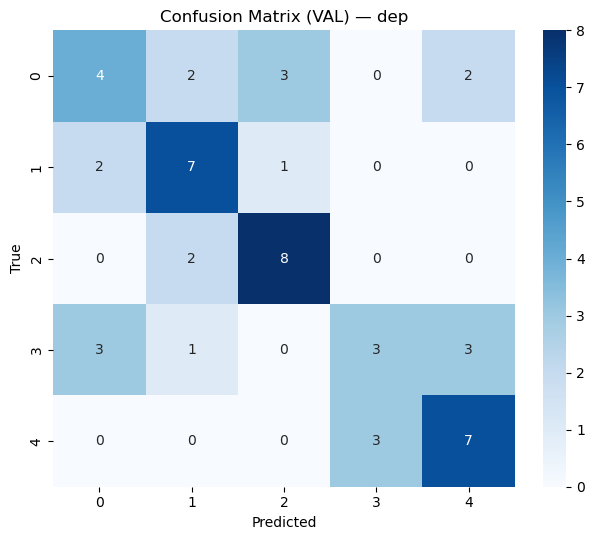


Classification Report (VAL):
               precision    recall  f1-score   support

           0     0.4444    0.3636    0.4000        11
           1     0.5833    0.7000    0.6364        10
           2     0.6667    0.8000    0.7273        10
           3     0.5000    0.3000    0.3750        10
           4     0.5833    0.7000    0.6364        10

    accuracy                         0.5686        51
   macro avg     0.5556    0.5727    0.5550        51
weighted avg     0.5534    0.5686    0.5520        51



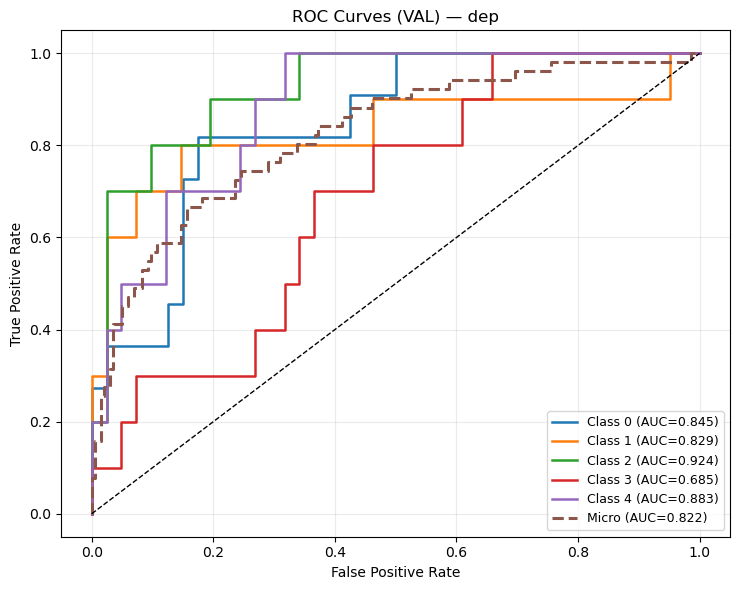


AUC-ROC (VAL): micro 0.8223 | macro 0.8335


In [13]:
# --- Split 2: Person-Dependent (adjust paths to your second split)
train_ids_B = read_ids_from_dir("Person-Dependent_Split/train")
val_ids_B   = read_ids_from_dir("Person-Dependent_Split/val")
train_df_B  = df[df["video_id"].isin(train_ids_B)].reset_index(drop=True)
val_df_B    = df[df["video_id"].isin(val_ids_B)].reset_index(drop=True)

res_B = run_split("dep", train_ids_B, val_ids_B)

# Test Predictions

In [29]:
import os
import json
import math
import copy
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
import pickle

FEATURE_DIR = "videomae_features_new"
CSV_PATH    = "FinalDataset.csv"

BATCH_SIZE_DEFAULT = 8        
N_EPOCHS    = 40
PATIENCE    = 8
SEED        = 42
INPUT_DIM   = 768             # feature dimension
NUM_WORKERS = 0
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PIN         = torch.cuda.is_available()

LABEL_COL_MAP = {
    "ind": "view_range_enc_ind",
    "dep": "view_range_enc_dep",
}

# Set seeds for reproducibility
def set_seed(seed=SEED):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

def worker_init_fn(worker_id):
    s = SEED + worker_id
    np.random.seed(s)
    torch.manual_seed(s)

set_seed()

def read_ids_from_dir(dir_path: str):
    assert os.path.isdir(dir_path), f"Missing directory: {dir_path}"
    return set(os.path.splitext(fn)[0] for fn in os.listdir(dir_path))

def get_dfs_for_split(split_tag: str):
    df = pd.read_csv(CSV_PATH)
    base = f"Person-{'Independent' if split_tag=='ind' else 'Dependent'}_Split"
    train_ids = read_ids_from_dir(os.path.join(base, "train"))
    val_ids   = read_ids_from_dir(os.path.join(base, "val"))
    test_ids  = read_ids_from_dir(os.path.join(base, "test"))

    trainval_ids = train_ids | val_ids
    trainval_df  = df[df.video_id.isin(trainval_ids)].reset_index(drop=True) # Combine train and validation dataframe
    test_df      = df[df.video_id.isin(test_ids)].reset_index(drop=True) # Get the test dataset

    need = {"video_id","channel_id","log_view_count","view_count",
            "view_range_enc_ind","view_range_enc_dep"}
    assert need.issubset(trainval_df.columns), f"Missing in trainval: {need - set(trainval_df.columns)}"
    assert need.issubset(test_df.columns), f"Missing in test: {need - set(test_df.columns)}"
    return trainval_df, test_df

def build_internal_val_from_labels(trainval_df: pd.DataFrame, split_tag: str,
                                   val_rel=0.15, seed=SEED):
    label_col = LABEL_COL_MAP[split_tag]
    assert label_col in trainval_df.columns, f"Missing {label_col}."
    assert "channel_id" in trainval_df.columns, "Missing channel_id."

    # Ensure integer-encoded labels 0..K-1
    y = pd.Series(trainval_df[label_col]).astype(str)
    if not y.str.fullmatch(r"\d+").all():
        y_int = pd.Series(pd.Categorical(y).codes).astype(int)
    else:
        y_int = y.astype(int)

    n_splits = max(2, int(round(1.0 / val_rel)))  # e.g., 0.15 -> ~7
    idx = np.arange(len(trainval_df))

    if split_tag == "ind":
        groups = trainval_df["channel_id"].values
        cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)  # no channel overlap for ind
        tr_idx, va_idx = next(cv.split(idx, y_int, groups=groups))
    else:
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)   # channel overlap for dep
        tr_idx, va_idx = next(cv.split(idx.reshape(-1,1), y_int))

    return tr_idx, va_idx, y_int

# Load best params/state 
def load_best_cls_bundle(split_tag: str):
    pt_path  = MODEL_DIR / f"video_cls_{split_tag}.pt"   # Load the best saved model
    pkl_path = MODEL_DIR / f"video_cls_bundle_{split_tag}.pkl"
    assert pt_path.exists(), f"Missing: {pt_path}"
    state_obj = torch.load(pt_path, map_location=DEVICE)
    if isinstance(state_obj, dict) and "state_dict" in state_obj:
        state_dict = state_obj["state_dict"]
    else:
        state_dict = state_obj  # saved raw state_dict

    best_params = None
    class_names = None
    num_classes = None
    if pkl_path.exists():
        with open(pkl_path, "rb") as f:
            bundle = pickle.load(f)
        best_params = bundle.get("best_params") or bundle.get("params")
        class_names = bundle.get("class_names")
        num_classes = bundle.get("num_classes")
        if num_classes is None and class_names is not None:
            num_classes = len(class_names)

    return state_dict, best_params, class_names, num_classes

# Train / Eval loops
def run_epoch(model, loader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    all_logits, all_targets = [], []
    running_loss, n_batches = 0.0, 0

    with torch.set_grad_enabled(is_train):
        for xb, yb in loader:
            xb = xb.to(DEVICE, non_blocking=True)
            yb = yb.to(DEVICE, non_blocking=True)

            logits = model(xb)      # forward pass
            loss = criterion(logits, yb)    # 

            if is_train:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

            all_logits.append(logits.detach().cpu())
            all_targets.append(yb.detach().cpu())

            running_loss += loss.item()
            n_batches += 1

    logits_np = torch.cat(all_logits, dim=0).numpy()
    targets_np = torch.cat(all_targets, dim=0).numpy()
    preds = logits_np.argmax(axis=1)
    acc = accuracy_score(targets_np, preds)
    f1  = f1_score(targets_np, preds, average="macro")

    return running_loss / max(n_batches, 1), acc, f1, logits_np, targets_np

# ======================= Runner (train+val -> test) ===========
def train_on_trainval_then_test_cls(split_tag: str):
    """
    Classification pipeline:
    - Load best params/state (if best_params missing, fall back to defaults)
    - Create one internal val from train+val via precomputed labels (no new bins)
    - Train CE, early stop on Val Accuracy
    - Evaluate on TEST: Acc, Macro-F1, per-class report, confusion, ROC-AUC (micro+macro)
    - Save predictions CSV + summary JSON
    """
    set_seed(SEED)
    print(f"\n===== [{split_tag}] CLS: Train+Val -> Test (labels from CSV) =====")

    # Dataframes
    trainval_df, test_df = get_dfs_for_split(split_tag)
    label_col = LABEL_COL_MAP[split_tag]
    print(f"train+val: {len(trainval_df)} | test: {len(test_df)} | label_col={label_col}")

    _, _, y_int = build_internal_val_from_labels(trainval_df, split_tag=split_tag, val_rel=0.15, seed=SEED)

    # Load best bundle (state dict + hyperparams)
    state_dict, best_params, class_names, num_classes = load_best_cls_bundle(split_tag)

    if best_params is None:
        # sensible defaults if bundle missing hyperparams
        best_params = {
            "batch_size": BATCH_SIZE_DEFAULT,
            "lr": 1e-3,
            "weight_decay": 1e-5,
            "nhead": 8,
            "num_layers": 2,
            "dim_ff": 1024,
            "dropout": 0.1
        }
    batch_size = int(best_params.get("batch_size", BATCH_SIZE_DEFAULT))

    # Build internal split
    tr_idx, va_idx, _ = build_internal_val_from_labels(trainval_df, split_tag=split_tag, val_rel=0.15, seed=SEED)
    tr_in = trainval_df.iloc[tr_idx].reset_index(drop=True)
    va_in = trainval_df.iloc[va_idx].reset_index(drop=True)
    print(f"internal train: {len(tr_in)} | internal val: {len(va_in)}")

    # Model
    model = TransformerClassifier(
        d_model=INPUT_DIM,
        nhead=int(best_params["nhead"]),
        num_layers=int(best_params["num_layers"]),
        num_classes=5
    ).to(DEVICE)
    # load pretrained/best weights as initialization
    model.load_state_dict(state_dict, strict=False)

    # Loaders
    g = torch.Generator().manual_seed(SEED)    # Reproducibility
    tr_loader = DataLoader(
        TemporalFeatureDataset(tr_in, feature_dir=FEATURE_DIR, target_column=label_col),
        batch_size=batch_size, shuffle=True, generator=g,
        num_workers=NUM_WORKERS, pin_memory=PIN,
        worker_init_fn=worker_init_fn if NUM_WORKERS>0 else None
    )
    va_loader = DataLoader(
        TemporalFeatureDataset(va_in, feature_dir=FEATURE_DIR, target_column=label_col),
        batch_size=batch_size, shuffle=False,                               # no shuffle
        num_workers=NUM_WORKERS, pin_memory=PIN,
        worker_init_fn=worker_init_fn if NUM_WORKERS>0 else None
    )
    te_loader = DataLoader(
        TemporalFeatureDataset(test_df, feature_dir=FEATURE_DIR, target_column=label_col),
        batch_size=batch_size, shuffle=False,                              # no shuffle
        num_workers=NUM_WORKERS, pin_memory=PIN,
        worker_init_fn=worker_init_fn if NUM_WORKERS>0 else None
    )

    # Train
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=float(best_params["lr"]), weight_decay=float(best_params["weight_decay"]))  # Get the best params

    best_acc, best_state, best_epoch, bad = -1.0, None, None, 0
    for ep in range(1, N_EPOCHS + 1):
        tr_loss, tr_acc, tr_f1, _, _ = run_epoch(model, tr_loader, criterion, optimizer)  # Train on train set
        va_loss, va_acc, va_f1, _, _ = run_epoch(model, va_loader, criterion, optimizer=None)  # Evaluate on the new val set
        print(f"Epoch {ep:02d} | Train: loss {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} || "
              f"Val: loss {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f}")
        if va_acc > best_acc:
            best_acc = float(va_acc)
            best_f1 = float(va_f1)
            best_state = copy.deepcopy(model.state_dict())
            best_epoch = ep
            bad = 0
        else:
            bad += 1
            if bad >= PATIENCE:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)     # Load the best model
    print(f"[{split_tag}] Best epoch: {best_epoch} | Best Val Acc={best_acc:.4f}")

    # Test evaluation
    te_loss, te_acc, te_f1, te_logits, te_targets = run_epoch(model, te_loader, criterion, optimizer=None)
    te_preds = te_logits.argmax(axis=1)

    # ROC-AUC (micro/macro) – needs one-vs-rest probabilities
    try:
        te_probs = torch.softmax(torch.tensor(te_logits), dim=1).numpy()
        classes = np.unique(np.concatenate([te_targets, te_preds]))
        y_true_bin = label_binarize(te_targets, classes=classes)
        auc_micro = roc_auc_score(y_true_bin, te_probs[:, classes], average="micro", multi_class="ovr")
        auc_macro = roc_auc_score(y_true_bin, te_probs[:, classes], average="macro", multi_class="ovr")
    except Exception as e:
        auc_micro = None
        auc_macro = None
        print(f"[{split_tag}] ROC-AUC not available ({e}).")

    cm = confusion_matrix(te_targets, te_preds)
    report = classification_report(te_targets, te_preds, digits=4, zero_division=0)

    print(f"[{split_tag}] TEST — Acc={te_acc:.4f} | Macro-F1={te_f1:.4f} | "
          f"ROC-AUC micro={auc_micro if auc_micro is not None else 'n/a'} "
          f"macro={auc_macro if auc_macro is not None else 'n/a'}")
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", report)

    # Save predictions CSV
    out = test_df[["video_id","channel_id", label_col]].copy()
    out = out.rename(columns={label_col: "y_true"})
    out["pred"] = te_preds
    # also save probabilities per class if available
    if 'te_probs' in locals():
        for c in range(te_probs.shape[1]):
            out[f"prob_{c}"] = te_probs[:, c]
            
    save_csv = RESULTS_DIR / f"video_cls_test_{split_tag}.csv"
    out.to_csv(save_csv, index=False)
    print(f"[{split_tag}] Saved test predictions to: {save_csv}")

    # --- SAVE THE FINAL (refit) MODEL BUNDLE
    final_bundle = {
        "state_dict": model.state_dict(),
        "best_params": best_params,
        "internal_val_acc": best_acc,
        "internal_val_f1": best_f1,
        "seed": SEED,
    }
    final_path = MODEL_DIR / f"video_reg_final_{split_tag}.pt"
    torch.save(final_bundle, final_path)
    print(f"[{split_tag}] Saved final model bundle to: {final_path}")

    return {
        "model": model,
        "test_acc": te_acc,
        "test_macro_f1": te_f1,
        "roc_auc_micro": auc_micro,
        "roc_auc_macro": auc_macro,
        "preds_path": save_csv,
        "best_epoch": best_epoch
    }

res_ind_cls = train_on_trainval_then_test_cls("ind")
res_dep_cls = train_on_trainval_then_test_cls("dep")


===== [ind] CLS: Train+Val -> Test (labels from CSV) =====
train+val: 350 | test: 150 | label_col=view_range_enc_ind


C:\Users\Mansi Jadhav\AppData\Local\Temp\ipykernel_25176\658662478.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_obj = torch.load(pt_path, map_location=DEVICE)

internal train: 295 | internal val: 55


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01 | Train: loss 1.8722 acc 0.2814 f1 0.2860 || Val: loss 1.3620 acc 0.4000 f1 0.3093
Epoch 02 | Train: loss 1.4726 acc 0.3831 f1 0.3836 || Val: loss 1.4384 acc 0.4545 f1 0.3170
Epoch 03 | Train: loss 1.3759 acc 0.3864 f1 0.3812 || Val: loss 1.3012 acc 0.6000 f1 0.5402
Epoch 04 | Train: loss 1.3552 acc 0.4271 f1 0.4283 || Val: loss 1.7878 acc 0.2909 f1 0.2562
Epoch 05 | Train: loss 1.4008 acc 0.3898 f1 0.3892 || Val: loss 1.4636 acc 0.4000 f1 0.2982
Epoch 06 | Train: loss 1.2501 acc 0.4475 f1 0.4512 || Val: loss 1.3003 acc 0.4909 f1 0.4897
Epoch 07 | Train: loss 1.2385 acc 0.4915 f1 0.4887 || Val: loss 1.5382 acc 0.4545 f1 0.4322
Epoch 08 | Train: loss 1.2766 acc 0.4610 f1 0.4601 || Val: loss 1.5471 acc 0.3636 f1 0.2755
Epoch 09 | Train: loss 1.2303 acc 0.4983 f1 0.4841 || Val: loss 1.2786 acc 0.4545 f1 0.3854
Epoch 10 | Train: loss 1.0870 acc 0.5458 f1 0.5430 || Val: loss 1.6316 acc 0.2545 f1 0.2334
Epoch 11 | Train: loss 1.2971 acc 0.4814 f1 0.4773 || Val: loss 1.4452 acc 0.418

C:\Users\Mansi Jadhav\AppData\Local\Temp\ipykernel_25176\658662478.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_obj = torch.load(pt_path, map_location=DEVICE)

Epoch 01 | Train: loss 3.0376 acc 0.2933 f1 0.2924 || Val: loss 1.7017 acc 0.3800 f1 0.2844
Epoch 02 | Train: loss 1.5654 acc 0.4100 f1 0.3841 || Val: loss 1.5102 acc 0.3200 f1 0.2381
Epoch 03 | Train: loss 1.4508 acc 0.3467 f1 0.3363 || Val: loss 1.9688 acc 0.2800 f1 0.1595
Epoch 04 | Train: loss 1.4198 acc 0.3733 f1 0.3613 || Val: loss 1.5721 acc 0.2800 f1 0.2476
Epoch 05 | Train: loss 1.3637 acc 0.4033 f1 0.3632 || Val: loss 1.6315 acc 0.3400 f1 0.2620
Epoch 06 | Train: loss 1.3840 acc 0.3967 f1 0.3912 || Val: loss 1.8669 acc 0.2400 f1 0.1878
Epoch 07 | Train: loss 1.3612 acc 0.4233 f1 0.4173 || Val: loss 1.6808 acc 0.3600 f1 0.3096
Epoch 08 | Train: loss 1.3266 acc 0.4167 f1 0.3994 || Val: loss 1.8099 acc 0.3000 f1 0.2333
Epoch 09 | Train: loss 1.3350 acc 0.4300 f1 0.4288 || Val: loss 1.6315 acc 0.3000 f1 0.2595
Early stopping.
[dep] Best epoch: 1 | Best Val Acc=0.3800
[dep] TEST — Acc=0.2933 | Macro-F1=0.2115 | ROC-AUC micro=0.6275444444444445 macro=0.6072877857860488

Confusion M